# Workload-Variant-Autoscaler (WVA) Performance Analysis

This notebook analyzes WVA controller logs to visualize autoscaling behavior, warmup gaps, and SLO compliance.

**Workflow:**
1. Extract metrics from WVA controller logs using the bash script
2. Load and process the CSV data
3. Detect scaling phases and warmup gaps
4. Visualize performance metrics and scaling behavior
5. Perform statistical analysis

## 1. Setup and Configuration

In [132]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
import subprocess
from datetime import datetime
import os

# Plotting style
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Configuration
LOG_DIR = f'./txt_logs'
# LOG_NAME = 'ttft_queuescorer_SLO_10_10_24'  # Change this to your log name
LOG_NAME = 'ttft_queuescorer_logs'  # Change this to your log name

LOG_FILE = f'{LOG_DIR}/{LOG_NAME}.txt'  # Change this to your log file
EXTRACT_SCRIPT = './extract_metrics.sh'
TARGET_ACCELERATOR = 'H100'  # Accelerator to extract tuner params from (H100, L40S, A100, etc.)

# Generate unique experiment directory based on timestamp
EXPERIMENT_NAME = datetime.now().strftime('%Y%m%d_%H%M%S')
EXPERIMENT_DIR = f'experiments/{EXPERIMENT_NAME}_{LOG_NAME}'
OUTPUT_CSV = f'{EXPERIMENT_DIR}/extracted_metrics.csv'

# Create experiment directory structure
os.makedirs(f'{EXPERIMENT_DIR}/plots', exist_ok=True)
os.makedirs(f'{EXPERIMENT_DIR}/data', exist_ok=True)
os.makedirs(f'{EXPERIMENT_DIR}/analysis', exist_ok=True)

print(f"✅ Configuration loaded")
print(f"   Experiment: {EXPERIMENT_NAME}")
print(f"   Experiment directory: {EXPERIMENT_DIR}")
print(f"   Log file: {LOG_FILE}")
print(f"   Extract script: {EXTRACT_SCRIPT}")
print(f"   Target accelerator: {TARGET_ACCELERATOR}")
print(f"   Output CSV: {OUTPUT_CSV}")

✅ Configuration loaded
   Experiment: 20251209_141622
   Experiment directory: experiments/20251209_141622_ttft_queuescorer_logs
   Log file: ./txt_logs/ttft_queuescorer_logs.txt
   Extract script: ./extract_metrics.sh
   Target accelerator: H100
   Output CSV: experiments/20251209_141622_ttft_queuescorer_logs/extracted_metrics.csv


In [133]:
# ====================================================================
# PLOT CONFIGURATION
# ====================================================================

# Warmup background visualization (disabled by default)
SHOW_WARMUP_BACKGROUNDS = False  # Set to True to display warmup gap backgrounds in plots

# X-axis granularity configuration (in minutes)
X_MAJOR_TICK_INTERVAL = 1.0  # Major tick every 1 minute
X_MINOR_TICK_INTERVAL = 0.5  # Minor tick every 0.5 minutes (30 seconds)

print("="*70)
print("PLOT CONFIGURATION")
print("="*70)
print(f"   Warmup backgrounds: {'✓ ENABLED' if SHOW_WARMUP_BACKGROUNDS else '✗ DISABLED'}")
print(f"   X-axis major ticks: every {X_MAJOR_TICK_INTERVAL} minutes")
print(f"   X-axis minor ticks: every {X_MINOR_TICK_INTERVAL} minutes")
print("="*70)

PLOT CONFIGURATION
   Warmup backgrounds: ✗ DISABLED
   X-axis major ticks: every 1.0 minutes
   X-axis minor ticks: every 0.5 minutes


**📊 X-Axis Granularity Settings:**
- **Major ticks** (bold lines with labels): Every **0.5 minutes** (30 seconds)
- **Minor ticks** (light grid lines): Every **0.1 minutes** (6 seconds)

💡 *To adjust granularity, change `X_MAJOR_TICK_INTERVAL` and `X_MINOR_TICK_INTERVAL` above:*
- For **coarser** view: Use 1.0 (major) and 0.5 (minor) for 1-minute intervals
- For **finer** view: Use 0.25 (major) and 0.05 (minor) for 15-second intervals
- For **very fine** view: Use 0.1 (major) and 0.02 (minor) for 6-second intervals

## 2. Extract Metrics from Logs

Run the bash script to parse the WVA controller logs and extract optimization metrics.

In [134]:
# Make the script executable
!chmod +x {EXTRACT_SCRIPT}

# Run the extraction script with target accelerator
print(f"📊 Extracting metrics from {LOG_FILE}...")
print(f"   Targeting accelerator: {TARGET_ACCELERATOR}")
result = subprocess.run(
    [EXTRACT_SCRIPT, LOG_FILE, TARGET_ACCELERATOR],
    capture_output=True,
    text=True
)

# Save to CSV
with open(OUTPUT_CSV, 'w') as f:
    f.write(result.stdout)

print(f"✅ Metrics extracted to {OUTPUT_CSV}")
print(f"   Lines extracted: {len(result.stdout.splitlines())}")

# Preview the first few lines
print("\n📋 Preview of extracted data:")
!head -5 {OUTPUT_CSV}

📊 Extracting metrics from ./txt_logs/ttft_queuescorer_logs.txt...
   Targeting accelerator: H100
✅ Metrics extracted to experiments/20251209_141622_ttft_queuescorer_logs/extracted_metrics.csv
   Lines extracted: 69

📋 Preview of extracted data:
timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft,alpha,beta,gamma,delta
2025-10-20T16:24:26.275Z,0,0,0,0,0,1,7.514,15.415337,9,1000,7.47,0.044,15.415,0.000337
2025-10-20T16:24:26.291Z,0,0,0,0,0,1,7.514,15.415337,9,1000,7.47,0.044,15.415,0.000337
2025-10-20T16:25:26.330Z,0,0,0,0,0,1,7.514,15.415337,9,1000,7.47,0.044,15.415,0.000337
2025-10-20T16:25:26.351Z,0,0,0,0,0,1,7.514,15.415337,9,1000,7.47,0.044,15.415,0.000337
timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft,alpha,beta,gamma,delta
2025-10-20T16:24:26.275Z,0,0,0,0,0,1,7.514,15.415337,9,1000,7.47,0.044,15.415,0.000337
2025-10-20T16:24:26.291Z,0,0,0,0,0,1,7.514,15.415337,9,1000,7.47,0.044,15.415,0.000337
2025-10-20T16:25:26.330

## 3. Load and Process Data

### 3.1 Diagnostics (Run if you get errors)

In [135]:
print("🔍 Diagnosing extraction issue...\n")

# 1. Check log file
print(f"1. Log file check:")
log_path = LOG_FILE
BASH_SCRIPT = EXTRACT_SCRIPT
if os.path.exists(log_path):
    size = os.path.getsize(log_path)
    print(f"   ✓ File exists: {log_path}")
    print(f"   ✓ Size: {size:,} bytes")
    
    # Sample first few lines
    print(f"\n   First 5 lines of log file:")
    with open(log_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= 5:
                break
            print(f"   {i+1}: {line[:100]}...")
else:
    print(f"   ✗ File not found: {log_path}")

# 2. Check CSV output
print(f"\n2. CSV output check:")
if os.path.exists(OUTPUT_CSV):
    size = os.path.getsize(OUTPUT_CSV)
    print(f"   ✓ File exists: {OUTPUT_CSV}")
    print(f"   ✓ Size: {size:,} bytes")
    
    if size > 0:
        # Read CSV and show structure
        df_test = pd.read_csv(OUTPUT_CSV)
        print(f"   ✓ Rows: {len(df_test)}")
        print(f"   ✓ Columns: {list(df_test.columns)}")
        
        if len(df_test) > 0:
            print(f"\n   First row:")
            print(df_test.head(1).to_string())
        else:
            print(f"   ✗ CSV has no data rows (only headers)")
    else:
        print(f"   ✗ CSV is empty (0 bytes)")
else:
    print(f"   ✗ File not found: {OUTPUT_CSV}")

# 3. Check for JSON patterns in log file
print(f"\n3. Log format check:")
if os.path.exists(log_path):
    with open(log_path, 'r') as f:
        content = f.read()
        
    # Look for expected patterns
    has_optimization = 'optimizationMetrics' in content
    has_itl = 'itlAverage' in content or '"itl"' in content
    has_ttft = 'ttftAverage' in content or '"ttft"' in content
    
    print(f"   optimizationMetrics found: {'✓' if has_optimization else '✗'}")
    print(f"   ITL metrics found: {'✓' if has_itl else '✗'}")
    print(f"   TTFT metrics found: {'✓' if has_ttft else '✗'}")
    
    if not (has_optimization or has_itl):
        print(f"\n   ⚠️  Log file doesn't appear to contain expected metrics.")
        print(f"   Expected format: JSON with 'optimizationMetrics' field")
        print(f"\n   Sample expected format:")
        print(f'   {{"optimizationMetrics":{{"itlAverage":12.5,"ttftAverage":850,"rate":45.2,...}}}}')

print("\n" + "="*70)
print("If you see issues above, check:")
print("  1. Is LOG_FILE pointing to the correct WVA controller log file?")
print("  2. Does the log contain optimizationMetrics JSON entries?")
print("  3. Try running the extraction manually:")
print(f"     {BASH_SCRIPT} {LOG_FILE}")
print("="*70)

🔍 Diagnosing extraction issue...

1. Log file check:
   ✓ File exists: ./txt_logs/ttft_queuescorer_logs.txt
   ✓ Size: 383,807 bytes

   First 5 lines of log file:
   1: {"level":"INFO","ts":"2025-10-20T16:24:09.876Z","msg":"Zap logger initialized"}
...
   2: {"level":"INFO","ts":"2025-10-20T16:24:09.878Z","msg":"Creating metrics emitter instance"}
...
   3: {"level":"INFO","ts":"2025-10-20T16:24:09.878Z","msg":"Metrics emitter created successfully"}
...
   4: {"level":"INFO","ts":"2025-10-20T16:24:09.878Z","msg":"Using Prometheus configuration from environme...
   5: {"level":"WARN","ts":"2025-10-20T16:24:09.878Z","msg":"TLS certificate verification is disabled - th...

2. CSV output check:
   ✓ File exists: experiments/20251209_141622_ttft_queuescorer_logs/extracted_metrics.csv
   ✓ Size: 7,170 bytes
   ✓ Rows: 68
   ✓ Columns: ['timestamp', 'itlAverage', 'ttftAverage', 'rate', 'inTk', 'outTk', 'numRep', 'itl', 'ttft', 'slo_itl', 'slo_ttft', 'alpha', 'beta', 'gamma', 'delta']

   Fir

In [136]:
# Load the CSV data
df = pd.read_csv(OUTPUT_CSV)

# Check if data was extracted
if len(df) == 0:
    print("❌ ERROR: No data was extracted from the log file!")
    print("\nPossible issues:")
    print("1. Log file format doesn't match the extraction script")
    print("2. Log file doesn't contain optimization data")
    print("3. Log file path is incorrect")
    print(f"\nLog file: {LOG_FILE}")
    print(f"CSV file: {OUTPUT_CSV}")
    print("\nPlease check:")
    print("- Does the log file exist and have content?")
    print("- Does it contain lines with 'System data prepared for optimization'?")
    print("- Is the extraction script working correctly?")
    print("\nRun this to check the log file:")
    print(f"  !grep -i 'optimization' {LOG_FILE} | head -5")
    raise ValueError("No data extracted - please check log file and extraction script")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Deduplicate logs based on timestamp rounded to nearest minute (keep last occurrence)
# The extraction script creates near-duplicate entries with timestamps differing by seconds
initial_count = len(df)
df['timestamp_rounded'] = df['timestamp'].dt.floor('min')  # Round down to nearest minute
df = df.drop_duplicates(subset=['timestamp_rounded'], keep='last')
df = df.drop(columns=['timestamp_rounded'])  # Remove temporary column
dedupe_count = initial_count - len(df)

if dedupe_count > 0:
    print(f"🔄 Deduplication: Removed {dedupe_count} duplicate entries (kept last occurrence within each minute)")

# Calculate time in minutes from start
df['time_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60

# Display basic statistics
print("📊 Data Summary:")
print(f"   Duration: {df['time_minutes'].max():.1f} minutes")
print(f"   Data points: {len(df)}")
print(f"   Replica range: {df['numRep'].min():.0f} → {df['numRep'].max():.0f}")
print(f"   Load range: {df['rate'].min():.1f} → {df['rate'].max():.1f} rpm")
print(f"   SLO ITL: {df['slo_itl'].iloc[0]:.0f} ms")
print(f"   SLO TTFT: {df['slo_ttft'].iloc[0]:.0f} ms")

# Display first few rows
print("\n📋 Data preview:")
df.head(10)

🔄 Deduplication: Removed 34 duplicate entries (kept last occurrence within each minute)
📊 Data Summary:
   Duration: 33.1 minutes
   Data points: 34
   Replica range: 1 → 4
   Load range: 0.0 → 1569.4 rpm
   SLO ITL: 9 ms
   SLO TTFT: 1000 ms

📋 Data preview:


,timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft,alpha,beta,gamma,delta,time_minutes
1,2025-10-20 16:24:26.291000+00:00,0.00,0.00,0.00,0,0,1,7.514000,15.415337,9,1000,7.47,0.044,15.415,0.000337,0.000000
3,2025-10-20 16:25:26.351000+00:00,0.00,0.00,0.00,0,0,1,7.514000,15.415337,9,1000,7.47,0.044,15.415,0.000337,1.001000
5,2025-10-20 16:26:26.388000+00:00,9.43,19.62,296.00,290,371,1,8.174192,16.979109,9,1000,7.47,0.044,15.415,0.000337,2.001617
7,2025-10-20 16:27:26.476000+00:00,9.50,19.43,416.00,222,444,1,8.694328,17.496748,9,1000,7.47,0.044,15.415,0.000337,3.003083
9,2025-10-20 16:28:26.502000+00:00,9.71,19.88,422.00,258,477,1,8.818633,18.079962,9,1000,7.47,0.044,15.415,0.000337,4.003517
11,2025-10-20 16:29:26.530000+00:00,9.76,19.59,434.00,228,489,1,8.902365,17.916302,9,1000,7.47,0.044,15.415,0.000337,5.003983
13,2025-10-20 16:30:26.553000+00:00,9.53,18.74,428.90,222,469,1,8.817490,17.706161,9,1000,7.47,0.044,15.415,0.000337,6.004367
15,2025-10-20 16:31:26.585000+00:00,9.35,18.51,437.28,213,454,1,8.797618,17.580858,9,1000,7.47,0.044,15.415,0.000337,7.004900
17,2025-10-20 16:32:26.617000+00:00,9.57,18.75,440.88,221,489,1,8.928485,17.883718,9,1000,7.47,0.044,15.415,0.000337,8.005433
19,2025-10-20 16:33:26.643000+00:00,10.04,20.37,517.55,255,402,1,8.871004,18.151257,9,1000,7.47,0.044,15.415,0.000337,9.005867


## 4. Detect Scaling Events and Warmup Gaps

In [137]:
def detect_scaling_events(df, slo_threshold=None):
    """
    Detect scaling events and warmup gaps where actual TPOT exceeds SLO.
    """
    if slo_threshold is None:
        slo_threshold = df['slo_itl'].iloc[0]
    
    scaling_events = []
    warmup_gaps = []
    
    # Detect replica changes
    for i in range(1, len(df)):
        if df['numRep'].iloc[i] != df['numRep'].iloc[i-1]:
            scaling_events.append({
                'time': df['time_minutes'].iloc[i],
                'from_replicas': df['numRep'].iloc[i-1],
                'to_replicas': df['numRep'].iloc[i],
                'load': df['rate'].iloc[i]
            })
    
    # Detect warmup gaps (TPOT > SLO)
    in_gap = False
    gap_start = None
    
    for i in range(len(df)):
        tpot = df['itlAverage'].iloc[i]
        
        if tpot > slo_threshold and not in_gap:
            # Start of warmup gap
            in_gap = True
            gap_start = i
        elif tpot <= slo_threshold and in_gap:
            # End of warmup gap
            in_gap = False
            warmup_gaps.append({
                'start_time': df['time_minutes'].iloc[gap_start],
                'end_time': df['time_minutes'].iloc[i-1],
                'duration': df['time_minutes'].iloc[i-1] - df['time_minutes'].iloc[gap_start],
                'peak_violation': df['itlAverage'].iloc[gap_start:i].max(),
                'avg_tpot': df['itlAverage'].iloc[gap_start:i].mean(),
                'avg_load': df['rate'].iloc[gap_start:i].mean()
            })
    
    return scaling_events, warmup_gaps

# Detect events
scaling_events, warmup_gaps = detect_scaling_events(df)

print("🔄 Scaling Events Detected:")
for i, event in enumerate(scaling_events, 1):
    print(f"   {i}. t={event['time']:.1f}min: {event['from_replicas']:.0f} → {event['to_replicas']:.0f} replicas (load: {event['load']:.1f} rpm)")

print("\n⚠️  Warmup Gaps Detected (TPOT > SLO):")
for i, gap in enumerate(warmup_gaps, 1):
    print(f"   {i}. t={gap['start_time']:.1f}-{gap['end_time']:.1f}min ({gap['duration']:.1f}min)")
    print(f"      Peak: {gap['peak_violation']:.2f}ms, Avg: {gap['avg_tpot']:.2f}ms, Load: {gap['avg_load']:.0f} rpm")

🔄 Scaling Events Detected:
   1. t=10.0min: 1 → 2 replicas (load: 836.2 rpm)
   2. t=14.0min: 2 → 3 replicas (load: 1233.4 rpm)
   3. t=15.0min: 3 → 4 replicas (load: 1503.8 rpm)
   4. t=17.0min: 4 → 3 replicas (load: 1505.4 rpm)
   5. t=18.0min: 3 → 4 replicas (load: 1548.8 rpm)
   6. t=20.0min: 4 → 3 replicas (load: 1112.0 rpm)
   7. t=21.0min: 3 → 2 replicas (load: 712.5 rpm)
   8. t=28.0min: 2 → 1 replicas (load: 403.0 rpm)

⚠️  Warmup Gaps Detected (TPOT > SLO):
   1. t=2.0-20.0min (18.0min)
      Peak: 12.56ms, Avg: 10.53ms, Load: 869 rpm
   2. t=22.0-27.0min (5.0min)
      Peak: 9.73ms, Avg: 9.52ms, Load: 710 rpm
   3. t=29.0-32.1min (3.0min)
      Peak: 9.74ms, Avg: 9.48ms, Load: 284 rpm


## 5. Visualization: ITL Performance with Warmup Gaps

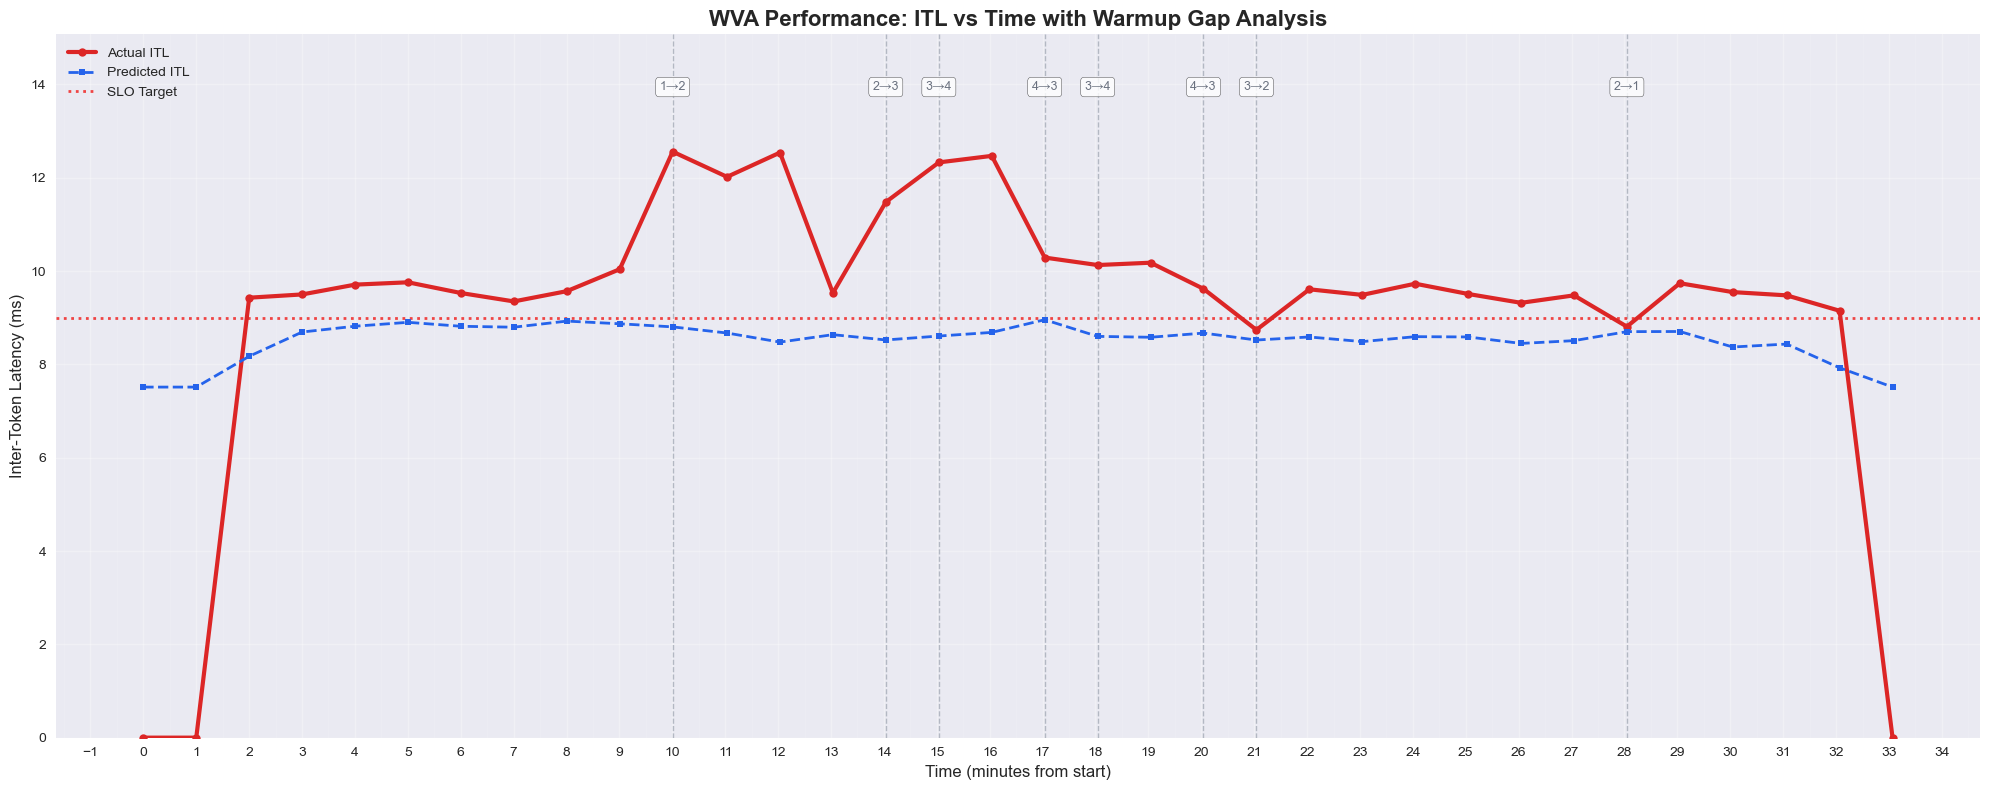

✅ Plot saved as 'experiments/20251209_141622_ttft_queuescorer_logs/plots/itl_analysis.png'


In [138]:
fig, ax = plt.subplots(figsize=(20, 8))

# Highlight warmup gaps (optional - controlled by SHOW_WARMUP_BACKGROUNDS)
if SHOW_WARMUP_BACKGROUNDS:
    for i, gap in enumerate(warmup_gaps):
        color = ['red', 'orange', 'yellow'][i % 3]
        rect = Rectangle(
            (gap['start_time'], 0),
            gap['end_time'] - gap['start_time'],
            df['itlAverage'].max() * 1.2,
            alpha=0.15,
            color=color,
            label=f"Warmup Gap {i+1}"
        )
        ax.add_patch(rect)

# Plot ITL metrics
ax.plot(df['time_minutes'], df['itlAverage'], 'o-', 
        linewidth=3, markersize=6, color='#dc2626', 
        label='Actual ITL', zorder=3)
ax.plot(df['time_minutes'], df['itl'], 's--', 
        linewidth=2, markersize=4, color='#2563eb', 
        label='Predicted ITL', zorder=3)
ax.axhline(y=df['slo_itl'].iloc[0], color='#ef4444', 
           linestyle=':', linewidth=2, label='SLO Target', zorder=2)

# Mark scaling events
for event in scaling_events:
    ax.axvline(x=event['time'], color='#9ca3af', 
               linestyle='--', alpha=0.7, linewidth=1, zorder=1)
    ax.text(event['time'], df['itlAverage'].max() * 1.1, 
            f"{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
            ha='center', va='bottom', fontsize=9, color='#6b7280',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('Time (minutes from start)', fontsize=12)
ax.set_ylabel('Inter-Token Latency (ms)', fontsize=12)
ax.set_title('WVA Performance: ITL vs Time with Warmup Gap Analysis', 
             fontweight='bold', fontsize=16)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, df['itlAverage'].max() * 1.2)

# Set x-axis granularity
ax.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax.grid(True, which='major', alpha=0.3, linewidth=1)
ax.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/itl_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

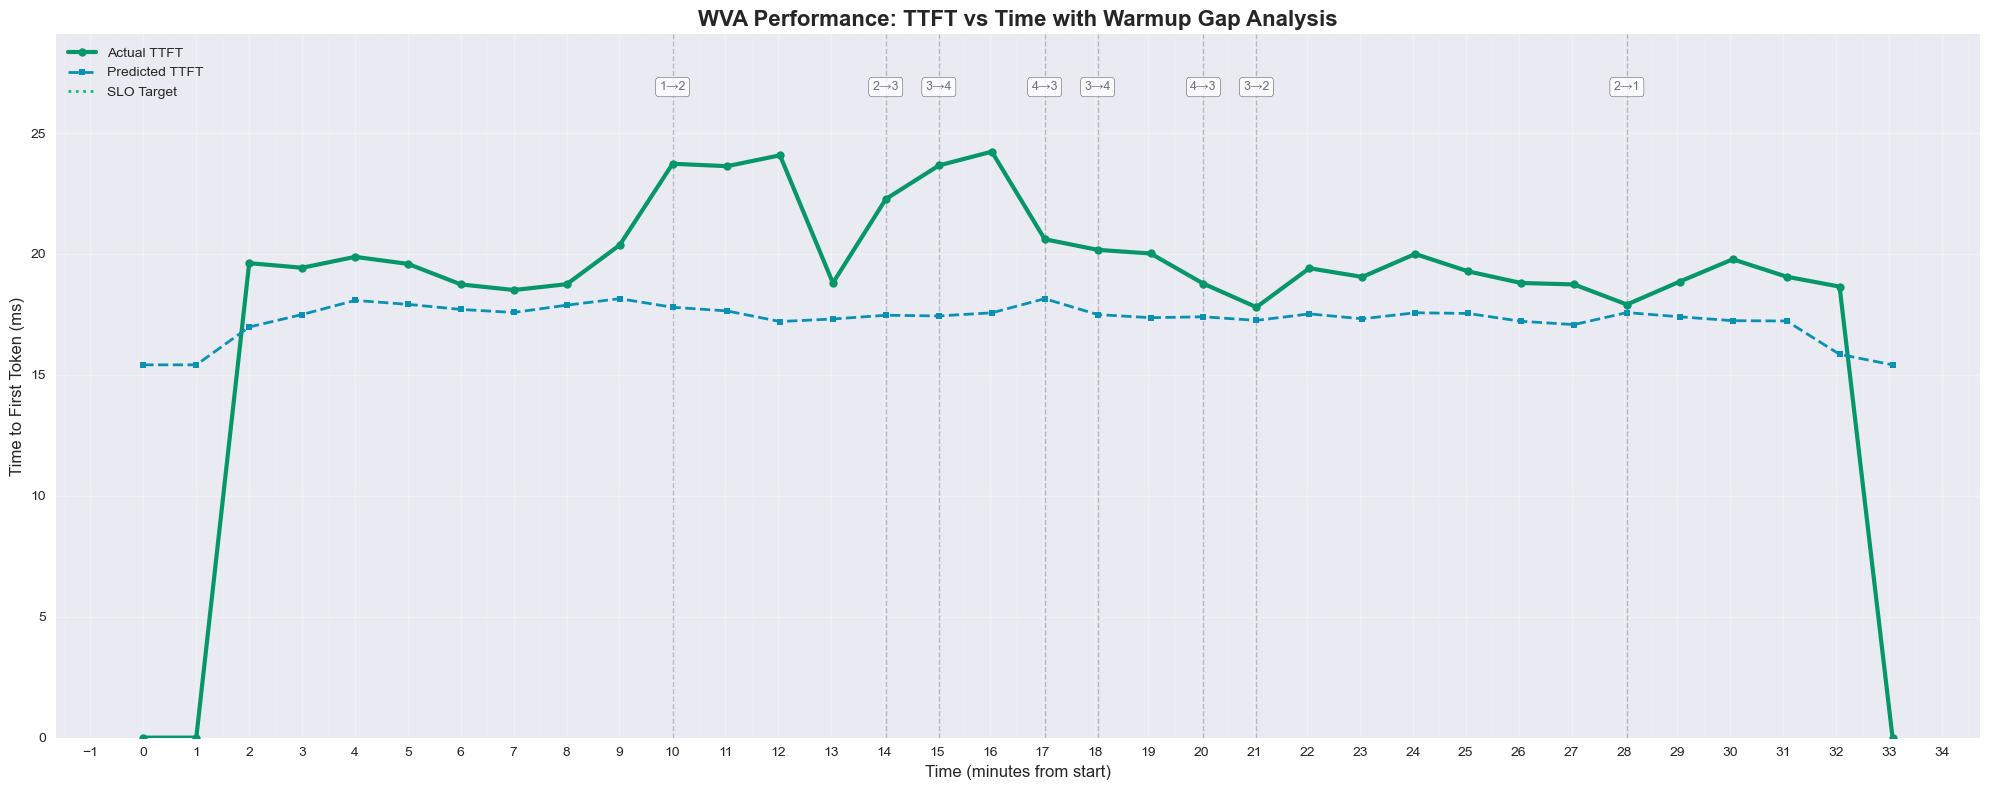

✅ Plot saved as 'experiments/20251209_141622_ttft_queuescorer_logs/plots/ttft_analysis.png'


In [139]:
fig, ax = plt.subplots(figsize=(20, 8))

# Highlight warmup gaps (optional - controlled by SHOW_WARMUP_BACKGROUNDS)
if SHOW_WARMUP_BACKGROUNDS:
    for i, gap in enumerate(warmup_gaps):
        color = ['red', 'orange', 'yellow'][i % 3]
        rect = Rectangle(
            (gap['start_time'], 0),
            gap['end_time'] - gap['start_time'],
            df['ttftAverage'].max() * 1.2,
            alpha=0.15,
            color=color,
            label=f"Warmup Gap {i+1}"
        )
        ax.add_patch(rect)

# Plot TTFT metrics
ax.plot(df['time_minutes'], df['ttftAverage'], 'o-', 
        linewidth=3, markersize=6, color='#059669', 
        label='Actual TTFT', zorder=3)
ax.plot(df['time_minutes'], df['ttft'], 's--', 
        linewidth=2, markersize=4, color='#0891b2', 
        label='Predicted TTFT', zorder=3)
ax.axhline(y=df['slo_ttft'].iloc[0], color='#10b981', 
           linestyle=':', linewidth=2, label='SLO Target', zorder=2)

# Mark scaling events
for event in scaling_events:
    ax.axvline(x=event['time'], color='#9ca3af', 
               linestyle='--', alpha=0.7, linewidth=1, zorder=1)
    ax.text(event['time'], df['ttftAverage'].max() * 1.1, 
            f"{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
            ha='center', va='bottom', fontsize=9, color='#6b7280',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('Time (minutes from start)', fontsize=12)
ax.set_ylabel('Time to First Token (ms)', fontsize=12)
ax.set_title('WVA Performance: TTFT vs Time with Warmup Gap Analysis', 
             fontweight='bold', fontsize=16)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, df['ttftAverage'].max() * 1.2)

# Set x-axis granularity
ax.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax.grid(True, which='major', alpha=0.3, linewidth=1)
ax.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/ttft_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 6. Visualization: TTFT Performance with Warmup Gaps

## 7. Visualization: Load Pattern Evolution

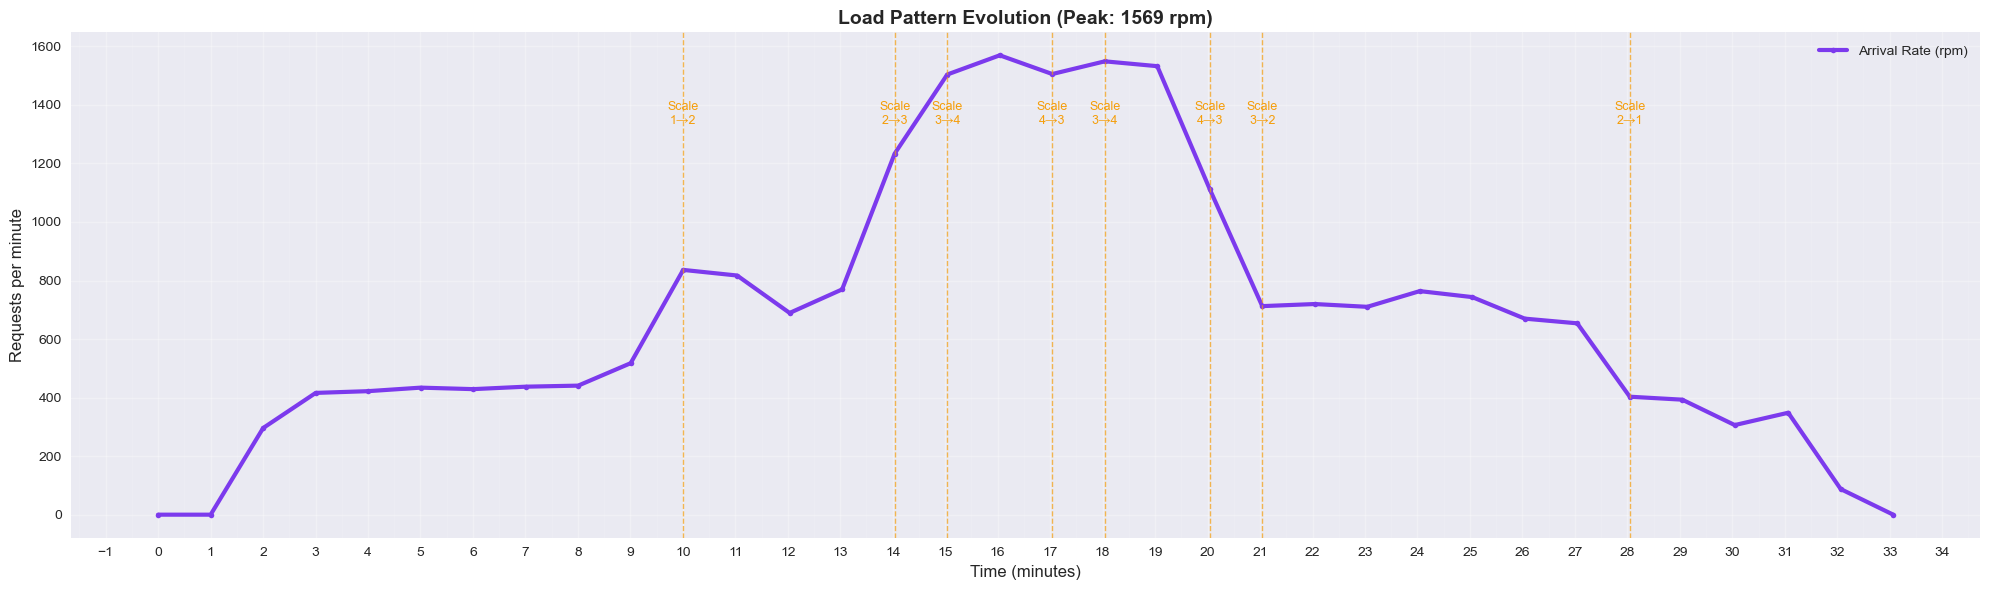

✅ Plot saved as 'experiments/20251209_141622_ttft_queuescorer_logs/plots/load_pattern.png'


In [140]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df['time_minutes'], df['rate'], 'o-', 
        linewidth=3, markersize=4, color='#7c3aed', 
        label='Arrival Rate (rpm)')

# Mark scaling events
for event in scaling_events:
    ax.axvline(x=event['time'], color='#f59e0b', 
               linestyle='--', alpha=0.7, linewidth=1)
    ax.text(event['time'], df['rate'].max() * 0.9,
            f"Scale\n{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
            ha='center', va='top', fontsize=9, color='#f59e0b')

ax.set_xlabel('Time (minutes)', fontsize=12)
ax.set_ylabel('Requests per minute', fontsize=12)
ax.set_title(f"Load Pattern Evolution (Peak: {df['rate'].max():.0f} rpm)",
             fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Set x-axis granularity
ax.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax.grid(True, which='major', alpha=0.3, linewidth=1)
ax.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/load_pattern.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 8. Visualization: ITL vs Replica Scaling Timeline

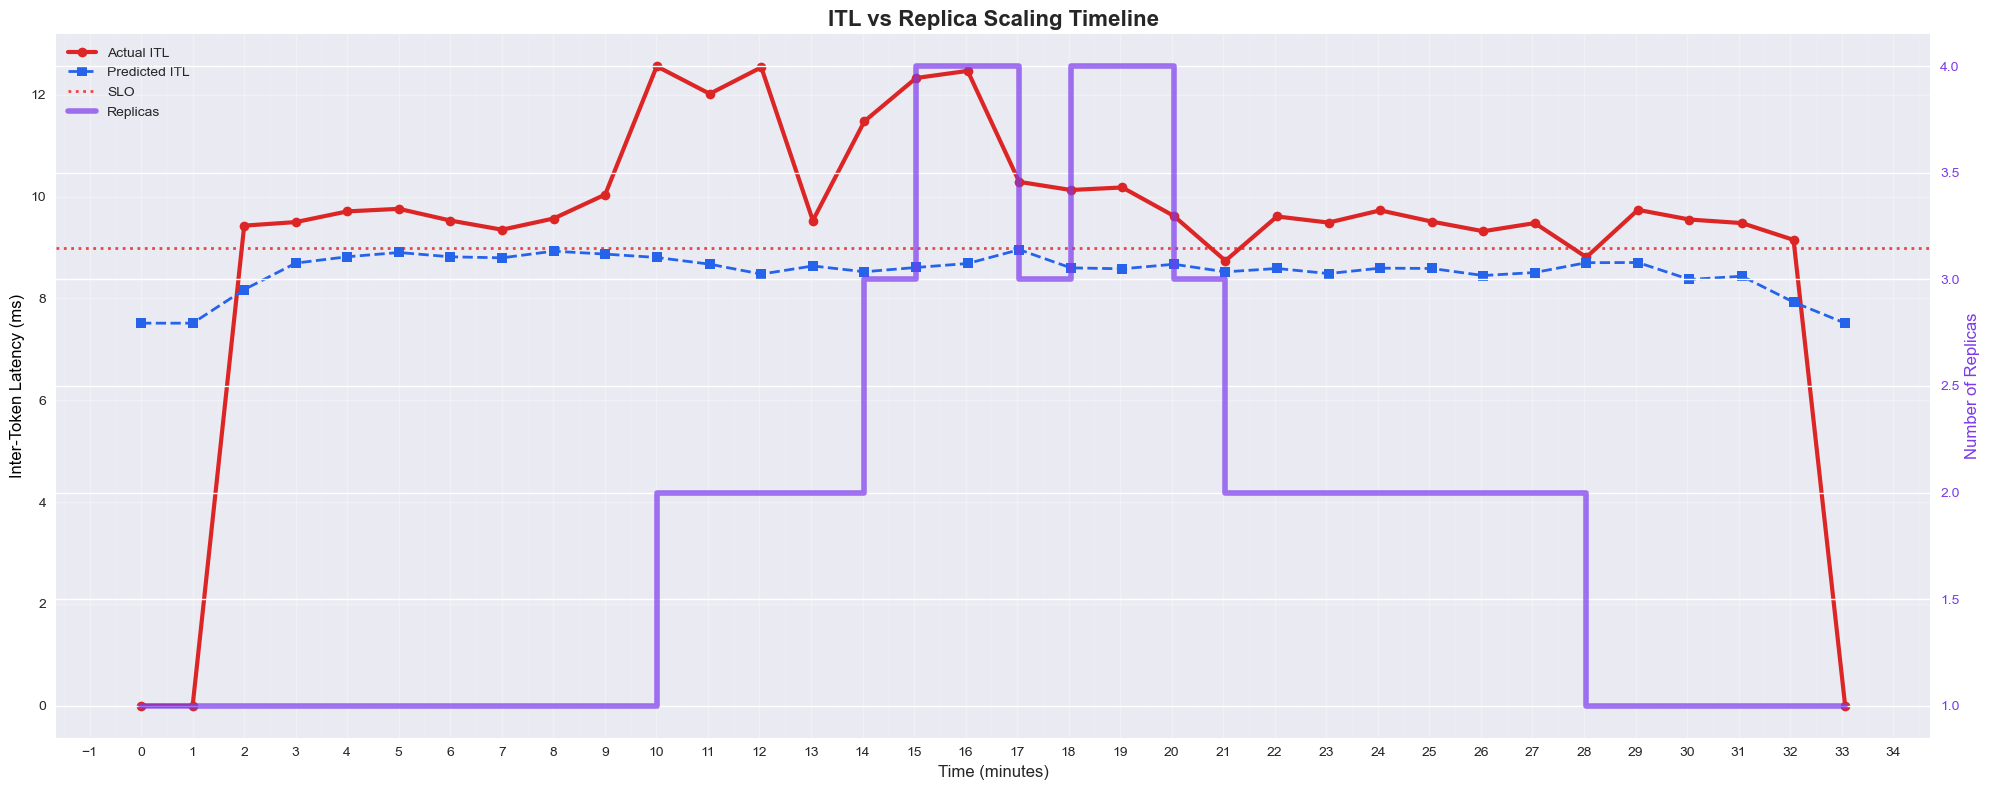

✅ Plot saved as 'experiments/20251209_141622_ttft_queuescorer_logs/plots/itl_replicas_timeline.png'


In [141]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# ITL on left axis
line1 = ax1.plot(df['time_minutes'], df['itlAverage'], 'o-', 
                 linewidth=3, color='#dc2626', label='Actual ITL', zorder=3)
line2 = ax1.plot(df['time_minutes'], df['itl'], 's--', 
                 linewidth=2, color='#2563eb', label='Predicted ITL', zorder=3)
ax1.axhline(y=df['slo_itl'].iloc[0], color='#ef4444', 
            linestyle=':', linewidth=2, label='SLO')

# Replicas on right axis
line3 = ax2.step(df['time_minutes'], df['numRep'], where='post',
                 linewidth=4, color='#7c3aed', alpha=0.7, label='Replicas')

# Highlight warmup gaps (optional - controlled by SHOW_WARMUP_BACKGROUNDS)
if SHOW_WARMUP_BACKGROUNDS:
    for gap in warmup_gaps:
        ax1.axvspan(gap['start_time'], gap['end_time'], 
                    alpha=0.1, color='red', zorder=1)

ax1.set_xlabel('Time (minutes)', fontsize=12)
ax1.set_ylabel('Inter-Token Latency (ms)', color='black', fontsize=12)
ax2.set_ylabel('Number of Replicas', color='#7c3aed', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#7c3aed')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_title('ITL vs Replica Scaling Timeline', fontweight='bold', fontsize=16)
ax1.grid(True, alpha=0.3)

# Set x-axis granularity
ax1.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax1.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/itl_replicas_timeline.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

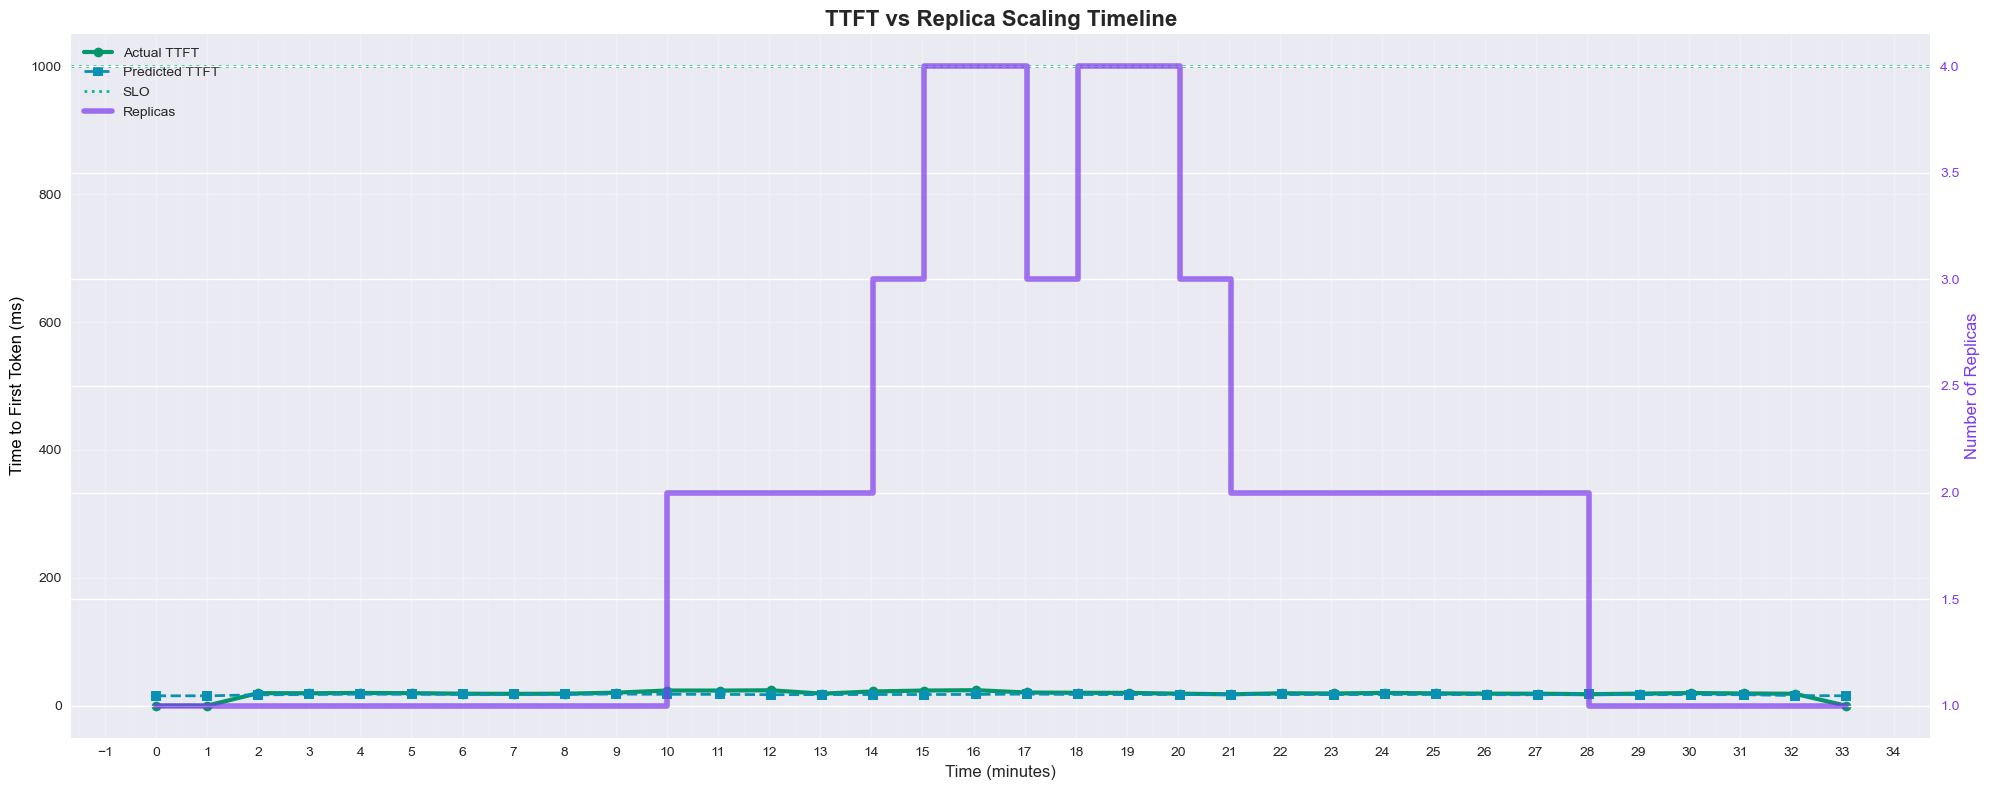

✅ Plot saved as 'experiments/20251209_141622_ttft_queuescorer_logs/plots/ttft_replicas_timeline.png'


In [142]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# TTFT on left axis
line1 = ax1.plot(df['time_minutes'], df['ttftAverage'], 'o-', 
                 linewidth=3, color='#059669', label='Actual TTFT', zorder=3)
line2 = ax1.plot(df['time_minutes'], df['ttft'], 's--', 
                 linewidth=2, color='#0891b2', label='Predicted TTFT', zorder=3)
ax1.axhline(y=df['slo_ttft'].iloc[0], color='#10b981', 
            linestyle=':', linewidth=2, label='SLO')

# Replicas on right axis
line3 = ax2.step(df['time_minutes'], df['numRep'], where='post',
                 linewidth=4, color='#7c3aed', alpha=0.7, label='Replicas')

# Highlight warmup gaps (optional - controlled by SHOW_WARMUP_BACKGROUNDS)
if SHOW_WARMUP_BACKGROUNDS:
    for gap in warmup_gaps:
        ax1.axvspan(gap['start_time'], gap['end_time'], 
                    alpha=0.1, color='red', zorder=1)

ax1.set_xlabel('Time (minutes)', fontsize=12)
ax1.set_ylabel('Time to First Token (ms)', color='black', fontsize=12)
ax2.set_ylabel('Number of Replicas', color='#7c3aed', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#7c3aed')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_title('TTFT vs Replica Scaling Timeline', fontweight='bold', fontsize=16)
ax1.grid(True, alpha=0.3)

# Set x-axis granularity
ax1.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax1.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/ttft_replicas_timeline.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 9. Visualization: TTFT vs Replica Scaling Timeline

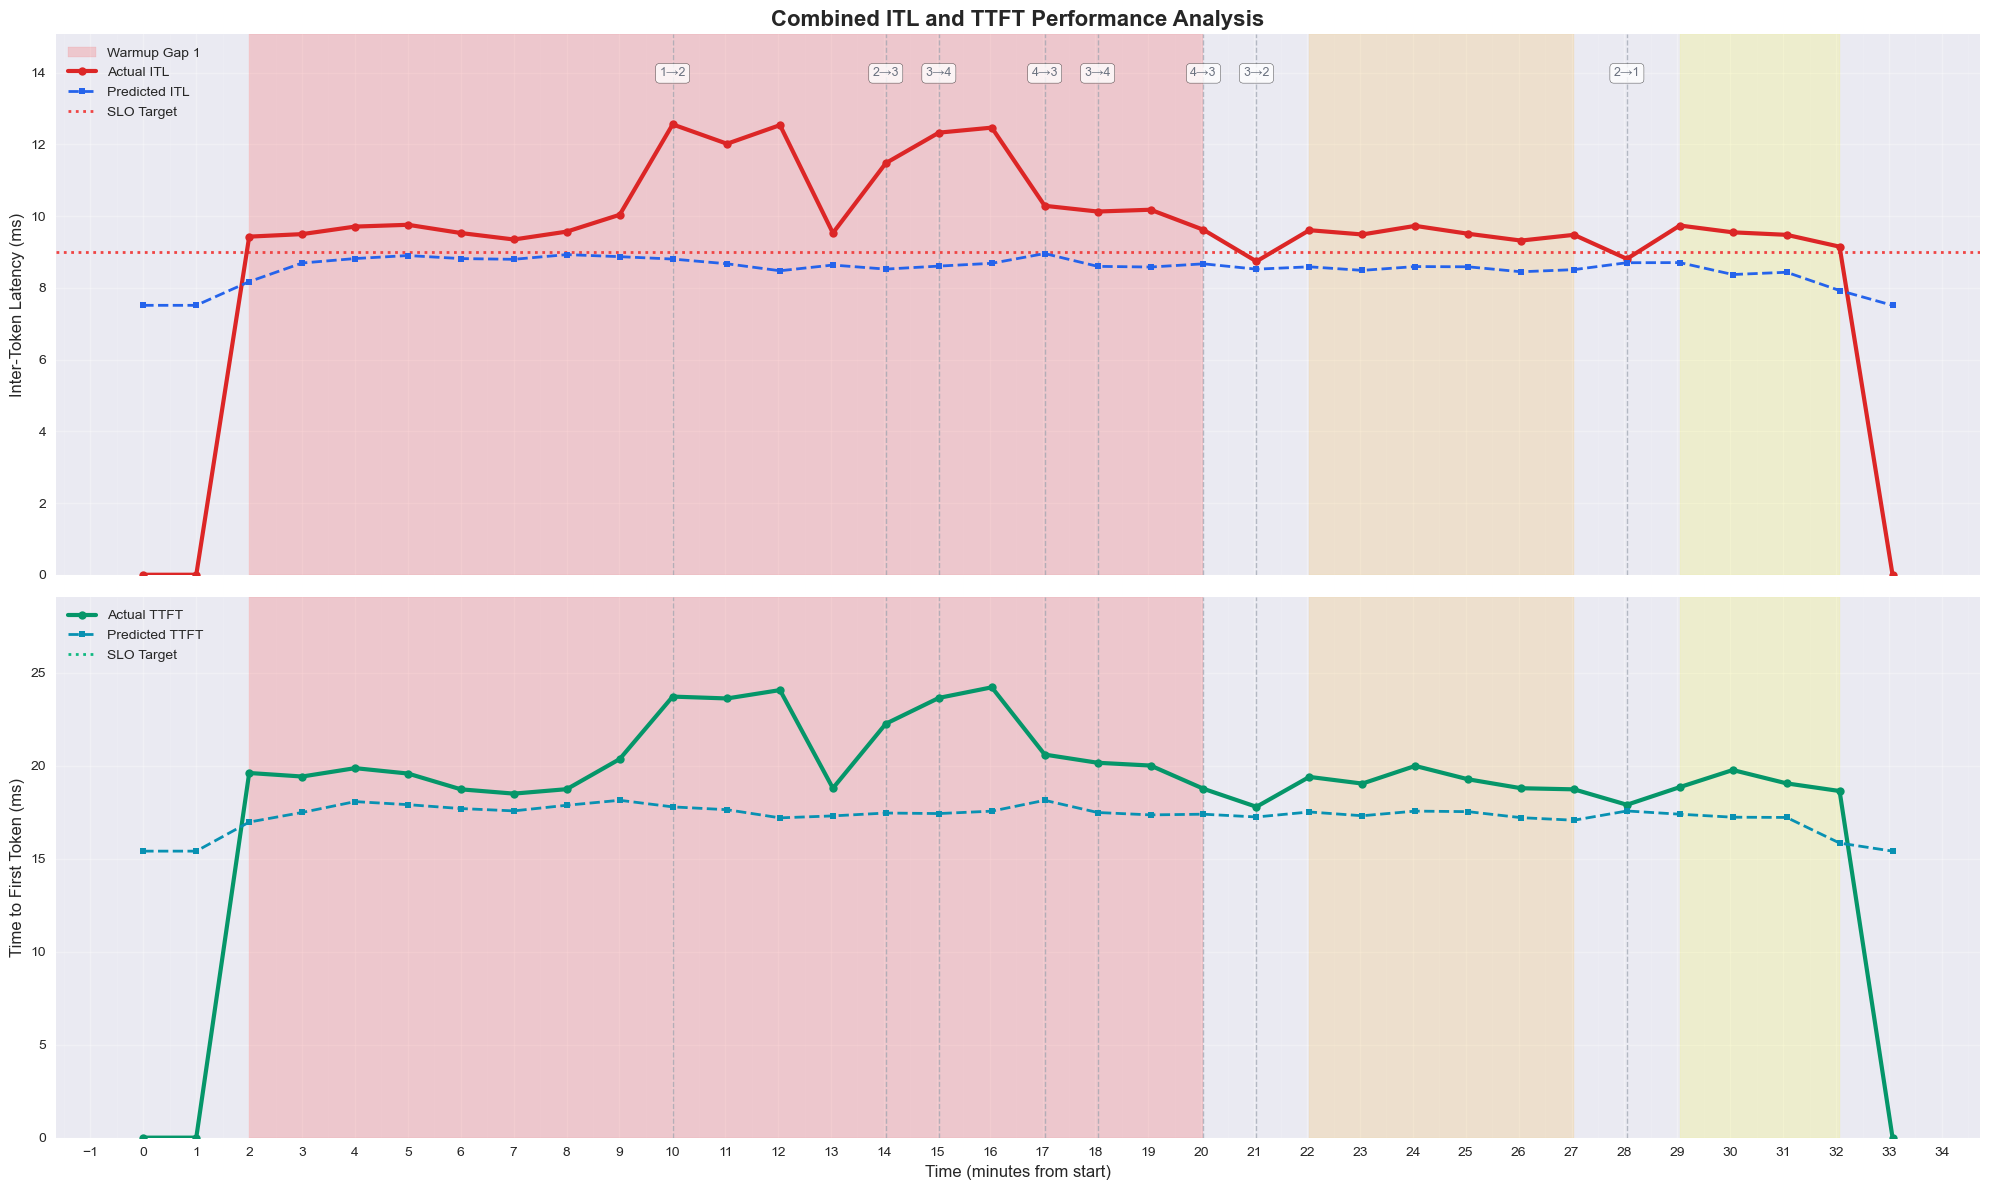

✅ Plot saved as 'experiments/20251209_141622_ttft_queuescorer_logs/plots/combined_itl_ttft.png'


In [143]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# ITL subplot
for i, gap in enumerate(warmup_gaps):
    color = ['red', 'orange', 'yellow'][i % 3]
    rect = Rectangle(
        (gap['start_time'], 0),
        gap['end_time'] - gap['start_time'],
        df['itlAverage'].max() * 1.2,
        alpha=0.15,
        color=color,
        label=f"Warmup Gap {i+1}" if i == 0 else ""
    )
    ax1.add_patch(rect)

ax1.plot(df['time_minutes'], df['itlAverage'], 'o-', 
         linewidth=3, markersize=6, color='#dc2626', label='Actual ITL', zorder=3)
ax1.plot(df['time_minutes'], df['itl'], 's--', 
         linewidth=2, markersize=4, color='#2563eb', label='Predicted ITL', zorder=3)
ax1.axhline(y=df['slo_itl'].iloc[0], color='#ef4444', 
            linestyle=':', linewidth=2, label='SLO Target', zorder=2)

for event in scaling_events:
    ax1.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.7, linewidth=1, zorder=1)
    ax1.text(event['time'], df['itlAverage'].max() * 1.1, 
             f"{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
             ha='center', va='bottom', fontsize=9, color='#6b7280',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax1.set_ylabel('Inter-Token Latency (ms)', fontsize=12)
ax1.set_title('Combined ITL and TTFT Performance Analysis', fontweight='bold', fontsize=16)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, df['itlAverage'].max() * 1.2)

# TTFT subplot
for i, gap in enumerate(warmup_gaps):
    color = ['red', 'orange', 'yellow'][i % 3]
    rect = Rectangle(
        (gap['start_time'], 0),
        gap['end_time'] - gap['start_time'],
        df['ttftAverage'].max() * 1.2,
        alpha=0.15,
        color=color
    )
    ax2.add_patch(rect)

ax2.plot(df['time_minutes'], df['ttftAverage'], 'o-', 
         linewidth=3, markersize=6, color='#059669', label='Actual TTFT', zorder=3)
ax2.plot(df['time_minutes'], df['ttft'], 's--', 
         linewidth=2, markersize=4, color='#0891b2', label='Predicted TTFT', zorder=3)
ax2.axhline(y=df['slo_ttft'].iloc[0], color='#10b981', 
            linestyle=':', linewidth=2, label='SLO Target', zorder=2)

for event in scaling_events:
    ax2.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.7, linewidth=1, zorder=1)

ax2.set_xlabel('Time (minutes from start)', fontsize=12)
ax2.set_ylabel('Time to First Token (ms)', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, df['ttftAverage'].max() * 1.2)

# Set x-axis granularity (applies to both subplots since sharex=True)
ax2.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax2.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)
ax2.grid(True, which='major', alpha=0.3, linewidth=1)
ax2.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/combined_itl_ttft.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 10. Visualization: Combined ITL & TTFT Analysis

## 11. Statistical Analysis

In [144]:
print("="*60)
print("WVA PERFORMANCE ANALYSIS SUMMARY")
print("="*60)
print(f"\n📊 Experiment Overview:")
print(f"   Experiment ID: {EXPERIMENT_NAME}")
print(f"   Duration: {df['time_minutes'].max():.1f} minutes")
print(f"   Data points: {len(df)}")
print(f"   Scaling pattern: {df['numRep'].min():.0f} → {df['numRep'].max():.0f} replicas")
print(f"   Peak load: {df['rate'].max():.0f} rpm")
print(f"   SLO ITL: {df['slo_itl'].iloc[0]:.0f} ms")
print(f"   SLO TTFT: {df['slo_ttft'].iloc[0]:.0f} ms")

print(f"\n⚠️  Warmup Gap Analysis:")
for i, gap in enumerate(warmup_gaps, 1):
    print(f"\n   Gap {i} (t={gap['start_time']:.1f}-{gap['end_time']:.1f}min):")
    print(f"      Duration: {gap['duration']:.1f} minutes")
    print(f"      Peak ITL violation: {gap['peak_violation']:.2f} ms")
    print(f"      Average ITL: {gap['avg_tpot']:.2f} ms")
    print(f"      Average load: {gap['avg_load']:.0f} rpm")
    print(f"      SLO exceedance: {gap['avg_tpot'] - df['slo_itl'].iloc[0]:.2f} ms")

print(f"\n📈 ITL Performance Metrics:")
print(f"   Mean ITL: {df['itlAverage'].mean():.2f} ms")
print(f"   Median ITL: {df['itlAverage'].median():.2f} ms")
print(f"   Peak ITL: {df['itlAverage'].max():.2f} ms")
print(f"   Min ITL: {df['itlAverage'].min():.2f} ms")
print(f"   Std Dev: {df['itlAverage'].std():.2f} ms")

print(f"\n📈 TTFT Performance Metrics:")
print(f"   Mean TTFT: {df['ttftAverage'].mean():.2f} ms")
print(f"   Median TTFT: {df['ttftAverage'].median():.2f} ms")
print(f"   Peak TTFT: {df['ttftAverage'].max():.2f} ms")
print(f"   Min TTFT: {df['ttftAverage'].min():.2f} ms")
print(f"   Std Dev: {df['ttftAverage'].std():.2f} ms")

# SLO compliance
itl_violations = df[df['itlAverage'] > df['slo_itl']]
ttft_violations = df[df['ttftAverage'] > df['slo_ttft']]
itl_compliance_rate = (1 - len(itl_violations) / len(df)) * 100
ttft_compliance_rate = (1 - len(ttft_violations) / len(df)) * 100

print(f"\n✅ SLO Compliance:")
print(f"   ITL Compliance: {itl_compliance_rate:.1f}%")
print(f"   ITL Violations: {len(itl_violations)} / {len(df)} data points")
print(f"   TTFT Compliance: {ttft_compliance_rate:.1f}%")
print(f"   TTFT Violations: {len(ttft_violations)} / {len(df)} data points")

print(f"\n🔄 Scaling Events:")
for i, event in enumerate(scaling_events, 1):
    print(f"   {i}. t={event['time']:.1f}min: {event['from_replicas']:.0f} → {event['to_replicas']:.0f} replicas (load: {event['load']:.1f} rpm)")

print("\n" + "="*60)

# Save summary to file
summary_path = f'{EXPERIMENT_DIR}/analysis/summary.txt'
with open(summary_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("WVA PERFORMANCE ANALYSIS SUMMARY\n")
    f.write("="*60 + "\n")
    f.write(f"\nExperiment ID: {EXPERIMENT_NAME}\n")
    f.write(f"Duration: {df['time_minutes'].max():.1f} minutes\n")
    f.write(f"ITL Compliance: {itl_compliance_rate:.1f}%\n")
    f.write(f"TTFT Compliance: {ttft_compliance_rate:.1f}%\n")
    f.write(f"Peak Load: {df['rate'].max():.0f} rpm\n")
    f.write(f"Scaling Pattern: {df['numRep'].min():.0f} → {df['numRep'].max():.0f} replicas\n")

print(f"\n✅ Summary saved to '{summary_path}'")

WVA PERFORMANCE ANALYSIS SUMMARY

📊 Experiment Overview:
   Experiment ID: 20251209_141622
   Duration: 33.1 minutes
   Data points: 34
   Scaling pattern: 1 → 4 replicas
   Peak load: 1569 rpm
   SLO ITL: 9 ms
   SLO TTFT: 1000 ms

⚠️  Warmup Gap Analysis:

   Gap 1 (t=2.0-20.0min):
      Duration: 18.0 minutes
      Peak ITL violation: 12.56 ms
      Average ITL: 10.53 ms
      Average load: 869 rpm
      SLO exceedance: 1.53 ms

   Gap 2 (t=22.0-27.0min):
      Duration: 5.0 minutes
      Peak ITL violation: 9.73 ms
      Average ITL: 9.52 ms
      Average load: 710 rpm
      SLO exceedance: 0.52 ms

   Gap 3 (t=29.0-32.1min):
      Duration: 3.0 minutes
      Peak ITL violation: 9.74 ms
      Average ITL: 9.48 ms
      Average load: 284 rpm
      SLO exceedance: 0.48 ms

📈 ITL Performance Metrics:
   Mean ITL: 9.20 ms
   Median ITL: 9.56 ms
   Peak ITL: 12.56 ms
   Min ITL: 0.00 ms
   Std Dev: 3.10 ms

📈 TTFT Performance Metrics:
   Mean TTFT: 18.30 ms
   Median TTFT: 19.34 ms
   P

## 12. Export Results

Export the processed data and analysis results for further use.

In [145]:
# Export processed data with phases
processed_csv = f'{EXPERIMENT_DIR}/data/processed_metrics.csv'
df.to_csv(processed_csv, index=False)
print(f"✅ Processed data exported to '{processed_csv}'")

# Export warmup gaps analysis
if warmup_gaps:
    gaps_df = pd.DataFrame(warmup_gaps)
    gaps_csv = f'{EXPERIMENT_DIR}/analysis/warmup_gaps.csv'
    gaps_df.to_csv(gaps_csv, index=False)
    print(f"✅ Warmup gaps analysis exported to '{gaps_csv}'")

# Export scaling events
if scaling_events:
    events_df = pd.DataFrame(scaling_events)
    events_csv = f'{EXPERIMENT_DIR}/analysis/scaling_events.csv'
    events_df.to_csv(events_csv, index=False)
    print(f"✅ Scaling events exported to '{events_csv}'")

# Copy original log file to experiment directory
import shutil
log_copy = f'{EXPERIMENT_DIR}/data/original_log.txt'
shutil.copy(LOG_FILE, log_copy)
print(f"✅ Original log file copied to '{log_copy}'")

# Create experiment manifest
manifest_path = f'{EXPERIMENT_DIR}/manifest.txt'
with open(manifest_path, 'w') as f:
    f.write(f"Experiment ID: {EXPERIMENT_NAME}\n")
    f.write(f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Log File: {LOG_FILE}\n")
    f.write(f"Duration: {df['time_minutes'].max():.1f} minutes\n")
    f.write(f"Data Points: {len(df)}\n")
    f.write(f"\nDirectory Structure:\n")
    f.write(f"  - data/: Raw and processed data files\n")
    f.write(f"  - plots/: Generated visualization plots\n")
    f.write(f"  - analysis/: Statistical analysis results\n")
    
print(f"✅ Manifest created at '{manifest_path}'")
print(f"\n📁 Experiment directory: {EXPERIMENT_DIR}")
print(f"   All outputs have been organized in subdirectories")

✅ Processed data exported to 'experiments/20251209_141622_ttft_queuescorer_logs/data/processed_metrics.csv'
✅ Warmup gaps analysis exported to 'experiments/20251209_141622_ttft_queuescorer_logs/analysis/warmup_gaps.csv'
✅ Scaling events exported to 'experiments/20251209_141622_ttft_queuescorer_logs/analysis/scaling_events.csv'
✅ Original log file copied to 'experiments/20251209_141622_ttft_queuescorer_logs/data/original_log.txt'
✅ Manifest created at 'experiments/20251209_141622_ttft_queuescorer_logs/manifest.txt'

📁 Experiment directory: experiments/20251209_141622_ttft_queuescorer_logs
   All outputs have been organized in subdirectories


## 13. Custom Analysis (Optional)

Use this cell for custom queries and exploration.

In [146]:
# Example: Find periods where predicted ITL underestimated actual ITL
itl_underestimation = df[df['itlAverage'] > df['itl']]
print("ITL Controller Underestimation Analysis:")
print(f"Occurred in {len(itl_underestimation)} / {len(df)} samples ({len(itl_underestimation)/len(df)*100:.1f}%)")
print(f"Average underestimation: {(itl_underestimation['itlAverage'] - itl_underestimation['itl']).mean():.2f} ms")

# Show samples with largest ITL underestimation
print("\nTop 5 largest ITL underestimations:")
itl_underestimation['gap'] = itl_underestimation['itlAverage'] - itl_underestimation['itl']
display(itl_underestimation.nlargest(5, 'gap')[['time_minutes', 'itlAverage', 'itl', 'gap', 'numRep', 'rate']])

# Example: Find periods where predicted TTFT underestimated actual TTFT
ttft_underestimation = df[df['ttftAverage'] > df['ttft']]
print("\nTTFT Controller Underestimation Analysis:")
print(f"Occurred in {len(ttft_underestimation)} / {len(df)} samples ({len(ttft_underestimation)/len(df)*100:.1f}%)")
print(f"Average underestimation: {(ttft_underestimation['ttftAverage'] - ttft_underestimation['ttft']).mean():.2f} ms")

# Show samples with largest TTFT underestimation
print("\nTop 5 largest TTFT underestimations:")
ttft_underestimation['gap'] = ttft_underestimation['ttftAverage'] - ttft_underestimation['ttft']
display(ttft_underestimation.nlargest(5, 'gap')[['time_minutes', 'ttftAverage', 'ttft', 'gap', 'numRep', 'rate']])

ITL Controller Underestimation Analysis:
Occurred in 31 / 34 samples (91.2%)
Average underestimation: 1.47 ms

Top 5 largest ITL underestimations:


/var/folders/w8/8n63220d7qnd2nmdqckjtls40000gn/T/ipykernel_61033/201466315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itl_underestimation['gap'] = itl_underestimation['itlAverage'] - itl_underestimation['itl']


,time_minutes,itlAverage,itl,gap,numRep,rate
25,12.035350,12.54,8.478154,4.061846,2,689.18
33,16.039767,12.47,8.686198,3.783802,4,1569.41
21,10.006783,12.56,8.804468,3.755532,2,836.23
31,15.039283,12.33,8.608094,3.721906,4,1503.77
23,11.034867,12.02,8.672937,3.347063,2,817.06



TTFT Controller Underestimation Analysis:
Occurred in 31 / 34 samples (91.2%)
Average underestimation: 2.61 ms

Top 5 largest TTFT underestimations:


/var/folders/w8/8n63220d7qnd2nmdqckjtls40000gn/T/ipykernel_61033/201466315.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttft_underestimation['gap'] = ttft_underestimation['ttftAverage'] - ttft_underestimation['ttft']


,time_minutes,ttftAverage,ttft,gap,numRep,rate
25,12.035350,24.08,17.206398,6.873602,2,689.18
33,16.039767,24.23,17.566760,6.663240,4,1569.41
31,15.039283,23.66,17.437290,6.222710,4,1503.77
23,11.034867,23.63,17.644646,5.985354,2,817.06
21,10.006783,23.73,17.796450,5.933550,2,836.23


## 14. Experiment Summary

Review the complete experiment directory structure and outputs.

In [147]:
import os
from pathlib import Path

print("="*70)
print(f"EXPERIMENT {EXPERIMENT_NAME} - COMPLETE")
print("="*70)

print(f"\n📁 Experiment Directory: {EXPERIMENT_DIR}")
print("\nDirectory Structure:")

# Walk through the experiment directory
for root, dirs, files in os.walk(EXPERIMENT_DIR):
    level = root.replace(EXPERIMENT_DIR, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        file_path = os.path.join(root, file)
        file_size = os.path.getsize(file_path)
        print(f'{subindent}📄 {file} ({file_size:,} bytes)')

print("\n" + "="*70)
print("Generated Outputs:")
print("="*70)

print("\n📊 Plots (6 visualizations):")
print("   1. itl_analysis.png - ITL performance with warmup gaps")
print("   2. ttft_analysis.png - TTFT performance with warmup gaps")
print("   3. load_pattern.png - Arrival rate evolution")
print("   4. itl_replicas_timeline.png - ITL vs replica scaling")
print("   5. ttft_replicas_timeline.png - TTFT vs replica scaling")
print("   6. combined_itl_ttft.png - Combined ITL & TTFT analysis")

print("\n📈 Data Files:")
print("   • extracted_metrics.csv - Raw extracted metrics")
print("   • processed_metrics.csv - Processed data with time calculations")
print("   • original_log.txt - Copy of original log file")

print("\n📋 Analysis Files:")
print("   • warmup_gaps.csv - Detected warmup gap statistics")
print("   • scaling_events.csv - Scaling event log")
print("   • summary.txt - Text summary of key findings")

print("\n📝 Experiment Metadata:")
print("   • manifest.txt - Experiment configuration and metadata")

print("\n" + "="*70)
print(f"✅ All outputs saved to: {EXPERIMENT_DIR}")
print("="*70)

EXPERIMENT 20251209_141622 - COMPLETE

📁 Experiment Directory: experiments/20251209_141622_ttft_queuescorer_logs

Directory Structure:
20251209_141622_ttft_queuescorer_logs/
  📄 manifest.txt (294 bytes)
  📄 extracted_metrics.csv (7,170 bytes)
  analysis/
    📄 summary.txt (310 bytes)
    📄 warmup_gaps.csv (293 bytes)
    📄 scaling_events.csv (258 bytes)
  data/
    📄 processed_metrics.csv (4,480 bytes)
    📄 original_log.txt (383,807 bytes)
  plots/
    📄 itl_analysis.png (366,165 bytes)
    📄 ttft_replicas_timeline.png (220,340 bytes)
    📄 itl_replicas_timeline.png (347,031 bytes)
    📄 combined_itl_ttft.png (591,678 bytes)
    📄 load_pattern.png (266,496 bytes)
    📄 ttft_analysis.png (370,294 bytes)

Generated Outputs:

📊 Plots (6 visualizations):
   1. itl_analysis.png - ITL performance with warmup gaps
   2. ttft_analysis.png - TTFT performance with warmup gaps
   3. load_pattern.png - Arrival rate evolution
   4. itl_replicas_timeline.png - ITL vs replica scaling
   5. ttft_repl

## 15. Calibration Analysis - Understanding the ITL Gap

This section analyzes the gap between predicted and observed ITL to identify calibration opportunities.

In [148]:
print("="*70)
print("CALIBRATION ANALYSIS: ITL Prediction Gap")
print("="*70)

# Calculate prediction error (Actual - Predicted)
# Positive error = underestimate (actual > predicted)
# Negative error = overestimate (actual < predicted)
df['itl_error'] = df['itlAverage'] - df['itl']
df['itl_error_pct'] = (df['itl_error'] / df['itl']) * 100

# Calculate effective batch size (approximation)
# effectiveBatch ≈ rate per replica / service rate
# For simplicity, we'll use a proxy: rate/numRep
df['rate_per_replica'] = df['rate'] / df['numRep']

print(f"\n📊 Prediction Error Statistics:")
print(f"   Mean Error (Actual - Predicted): {df['itl_error'].mean():.2f} ms")
print(f"   Median Error: {df['itl_error'].median():.2f} ms")
print(f"   Std Dev Error: {df['itl_error'].std():.2f} ms")
print(f"   Mean % Error: {df['itl_error_pct'].mean():.1f}%")

# Identify systematic bias (CORRECTED)
underestimates = df[df['itl_error'] > 0]  # Actual > Predicted
overestimates = df[df['itl_error'] < 0]   # Actual < Predicted

print(f"\n⚖️  Bias Analysis:")
print(f"   Predictions that UNDERESTIMATED: {len(underestimates)} / {len(df)} ({len(underestimates)/len(df)*100:.1f}%)")
print(f"      (Actual ITL > Predicted ITL - optimistic predictions)")
print(f"   Predictions that OVERESTIMATED: {len(overestimates)} / {len(df)} ({len(overestimates)/len(df)*100:.1f}%)")
print(f"      (Actual ITL < Predicted ITL - pessimistic predictions)")

if df['itl_error'].mean() > 0:
    print(f"\n   ⚠️  Overall: System tends to UNDERESTIMATE ITL (mean error: {df['itl_error'].mean():.2f}ms)")
    print(f"       → Predictions are too optimistic on average")
elif df['itl_error'].mean() < 0:
    print(f"\n   ℹ️  Overall: System tends to OVERESTIMATE ITL (mean error: {df['itl_error'].mean():.2f}ms)")
    print(f"       → Predictions are too pessimistic on average")
else:
    print(f"\n   ✓ Overall: System predictions are unbiased on average")

# Correlation with load
print(f"\n🔗 Correlation Analysis:")
print(f"   Error vs Rate: {df[['itl_error', 'rate']].corr().iloc[0,1]:.3f}")
print(f"   Error vs Replicas: {df[['itl_error', 'numRep']].corr().iloc[0,1]:.3f}")
print(f"   Error vs Rate/Replica: {df[['itl_error', 'rate_per_replica']].corr().iloc[0,1]:.3f}")

# Identify worst predictions (largest absolute errors)
print(f"\n❌ Top 5 Worst Predictions (Largest Absolute Errors):")
df['abs_error'] = df['itl_error'].abs()
worst = df.nlargest(5, 'abs_error')[['time_minutes', 'itlAverage', 'itl', 'itl_error', 
                                       'rate', 'numRep', 'rate_per_replica']]
display(worst)

print("\n" + "="*70)
print("💡 Calibration Opportunities:")
print("="*70)
print("1. Linear Regression: Fit alpha/beta to observed ITL vs load")
print("2. Query Prometheus: Get last 1h of ITL observations")
print("3. Filter Outliers: Remove anomalous points (> 2.5 std dev)")
print("4. Update Parameters: Use calibrated alpha/beta for predictions")
if abs(df['itl_error'].mean()) > 0.5:
    print(f"5. Expected Improvement: Reduce mean absolute error from {df['abs_error'].mean():.2f}ms")
    print(f"   Current bias: {df['itl_error'].mean():.2f}ms ({'under' if df['itl_error'].mean() > 0 else 'over'}estimation)")
print("="*70)

CALIBRATION ANALYSIS: ITL Prediction Gap

📊 Prediction Error Statistics:
   Mean Error (Actual - Predicted): 0.68 ms
   Median Error: 1.01 ms
   Std Dev Error: 2.80 ms
   Mean % Error: 6.7%

⚖️  Bias Analysis:
   Predictions that UNDERESTIMATED: 31 / 34 (91.2%)
      (Actual ITL > Predicted ITL - optimistic predictions)
   Predictions that OVERESTIMATED: 3 / 34 (8.8%)
      (Actual ITL < Predicted ITL - pessimistic predictions)

   ⚠️  Overall: System tends to UNDERESTIMATE ITL (mean error: 0.68ms)
       → Predictions are too optimistic on average

🔗 Correlation Analysis:
   Error vs Rate: 0.602
   Error vs Replicas: 0.435
   Error vs Rate/Replica: 0.783

❌ Top 5 Worst Predictions (Largest Absolute Errors):


,time_minutes,itlAverage,itl,itl_error,rate,numRep,rate_per_replica
1,0.000000,0.00,7.514000,-7.514000,0.00,1,0.0000
3,1.001000,0.00,7.514000,-7.514000,0.00,1,0.0000
67,33.067450,0.00,7.514000,-7.514000,0.00,1,0.0000
25,12.035350,12.54,8.478154,4.061846,689.18,2,344.5900
33,16.039767,12.47,8.686198,3.783802,1569.41,4,392.3525



💡 Calibration Opportunities:
1. Linear Regression: Fit alpha/beta to observed ITL vs load
2. Query Prometheus: Get last 1h of ITL observations
3. Filter Outliers: Remove anomalous points (> 2.5 std dev)
4. Update Parameters: Use calibrated alpha/beta for predictions
5. Expected Improvement: Reduce mean absolute error from 2.00ms
   Current bias: 0.68ms (underestimation)


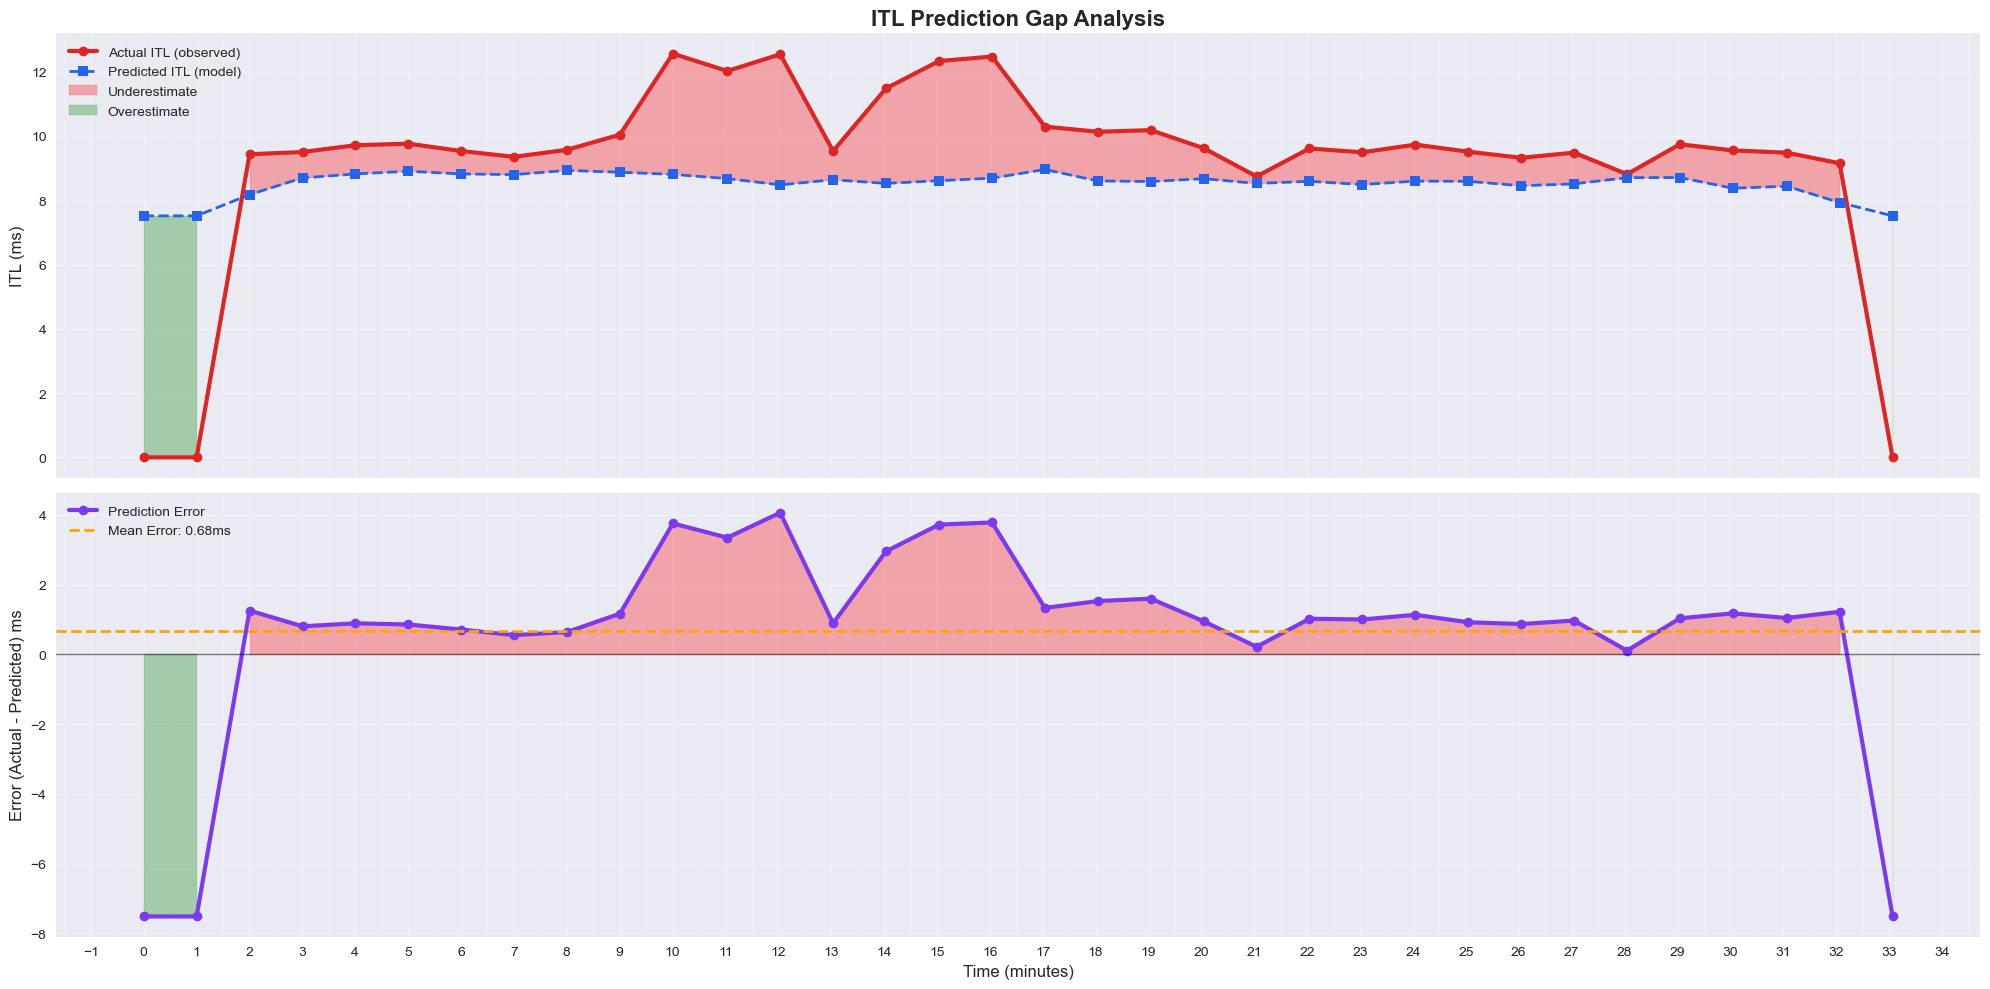

✅ Plot saved as 'experiments/20251209_141622_ttft_queuescorer_logs/plots/calibration_gap_analysis.png'


In [149]:
# Visualize prediction error over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Top: Predicted vs Actual ITL
ax1.plot(df['time_minutes'], df['itlAverage'], 'o-', 
         linewidth=3, color='#dc2626', label='Actual ITL (observed)', zorder=3)
ax1.plot(df['time_minutes'], df['itl'], 's--', 
         linewidth=2, color='#2563eb', label='Predicted ITL (model)', zorder=3)
ax1.fill_between(df['time_minutes'], df['itl'], df['itlAverage'], 
                  where=(df['itlAverage'] > df['itl']), 
                  alpha=0.3, color='red', label='Underestimate')
ax1.fill_between(df['time_minutes'], df['itl'], df['itlAverage'], 
                  where=(df['itlAverage'] <= df['itl']), 
                  alpha=0.3, color='green', label='Overestimate')
ax1.set_ylabel('ITL (ms)', fontsize=12)
ax1.set_title('ITL Prediction Gap Analysis', fontweight='bold', fontsize=16)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Bottom: Prediction Error
ax2.plot(df['time_minutes'], df['itl_error'], 'o-', 
         linewidth=3, color='#7c3aed', label='Prediction Error')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.axhline(y=df['itl_error'].mean(), color='orange', linestyle='--', 
            linewidth=2, label=f'Mean Error: {df["itl_error"].mean():.2f}ms')
ax2.fill_between(df['time_minutes'], 0, df['itl_error'], 
                  where=(df['itl_error'] > 0), alpha=0.3, color='red')
ax2.fill_between(df['time_minutes'], 0, df['itl_error'], 
                  where=(df['itl_error'] <= 0), alpha=0.3, color='green')
ax2.set_xlabel('Time (minutes)', fontsize=12)
ax2.set_ylabel('Error (Actual - Predicted) ms', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Set x-axis granularity
ax2.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax2.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)
ax2.grid(True, which='major', alpha=0.3, linewidth=1)
ax2.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/calibration_gap_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

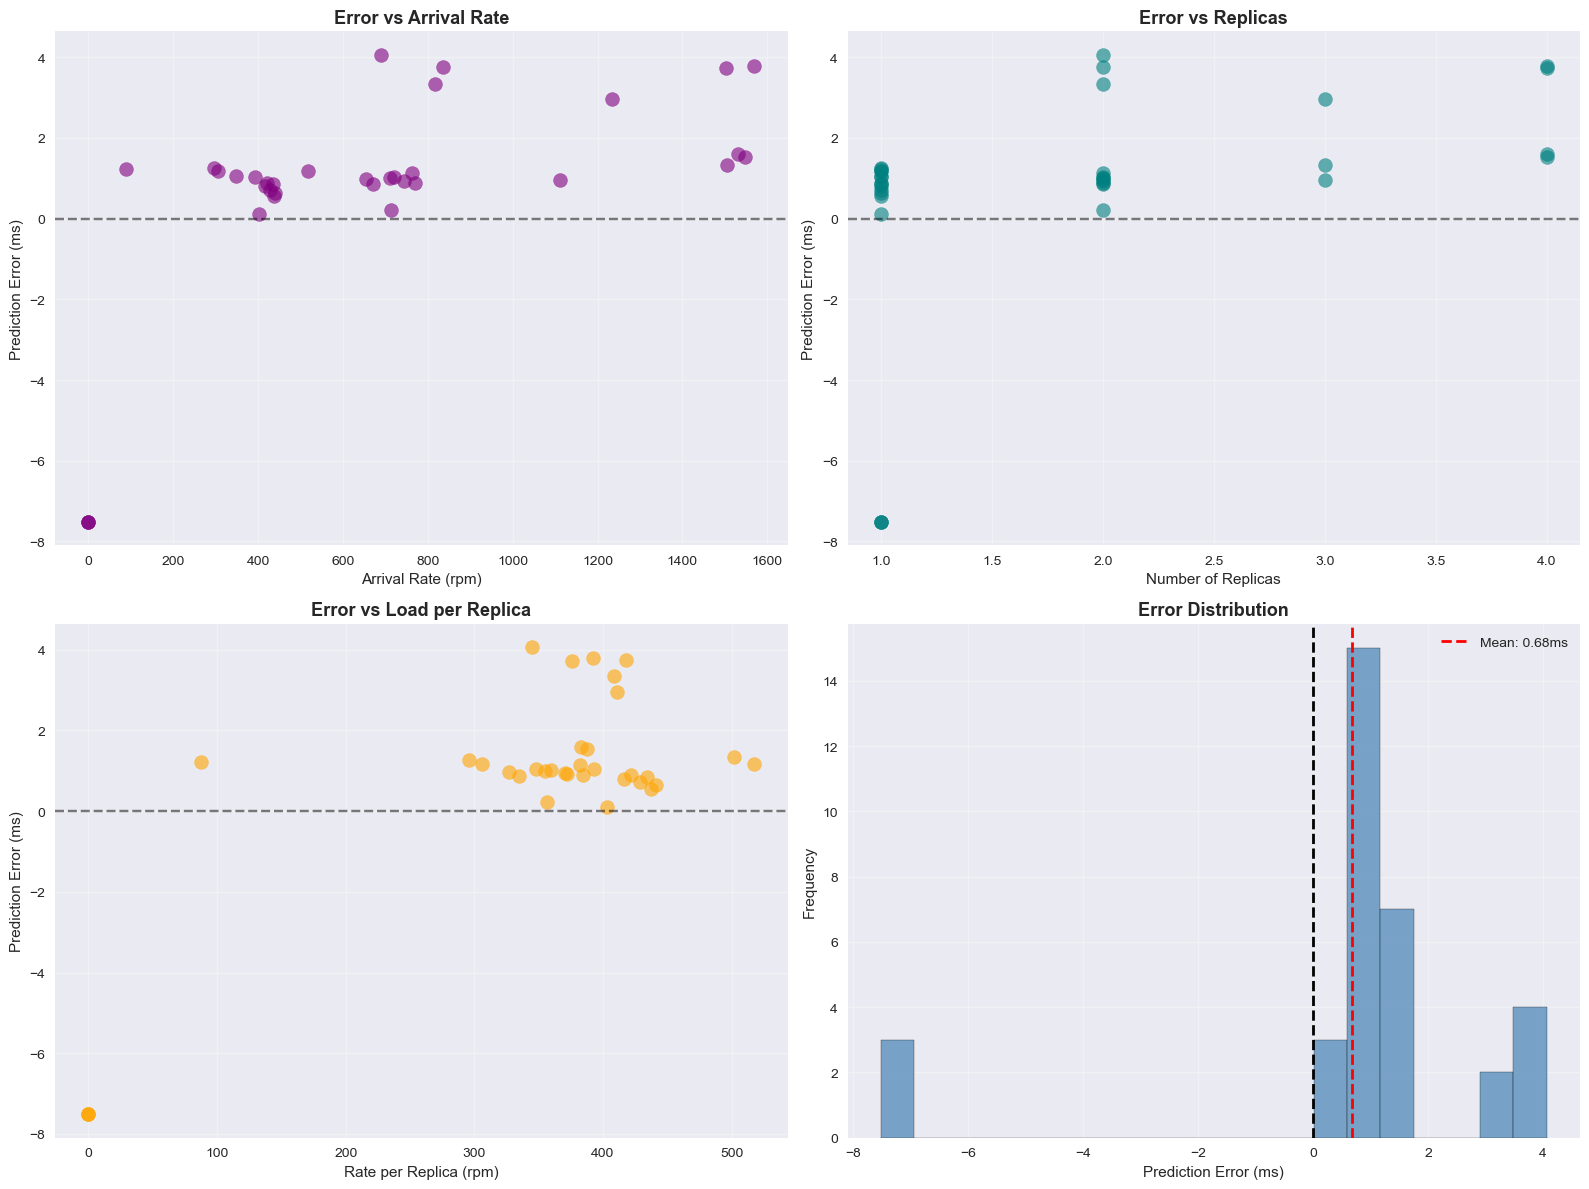

✅ Plot saved as 'experiments/20251209_141622_ttft_queuescorer_logs/plots/calibration_correlation_analysis.png'


In [150]:
# Scatter plot: Error vs Load characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Error vs Arrival Rate
axes[0, 0].scatter(df['rate'], df['itl_error'], alpha=0.6, s=100, c='purple')
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Arrival Rate (rpm)', fontsize=11)
axes[0, 0].set_ylabel('Prediction Error (ms)', fontsize=11)
axes[0, 0].set_title('Error vs Arrival Rate', fontweight='bold', fontsize=13)
axes[0, 0].grid(True, alpha=0.3)

# Error vs Number of Replicas
axes[0, 1].scatter(df['numRep'], df['itl_error'], alpha=0.6, s=100, c='teal')
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Number of Replicas', fontsize=11)
axes[0, 1].set_ylabel('Prediction Error (ms)', fontsize=11)
axes[0, 1].set_title('Error vs Replicas', fontweight='bold', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# Error vs Rate per Replica (proxy for batch size)
axes[1, 0].scatter(df['rate_per_replica'], df['itl_error'], alpha=0.6, s=100, c='orange')
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Rate per Replica (rpm)', fontsize=11)
axes[1, 0].set_ylabel('Prediction Error (ms)', fontsize=11)
axes[1, 0].set_title('Error vs Load per Replica', fontweight='bold', fontsize=13)
axes[1, 0].grid(True, alpha=0.3)

# Error distribution histogram
axes[1, 1].hist(df['itl_error'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=df['itl_error'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["itl_error"].mean():.2f}ms')
axes[1, 1].set_xlabel('Prediction Error (ms)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Error Distribution', fontweight='bold', fontsize=13)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/calibration_correlation_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 16. Model Parameter Evolution (Tuner Analysis)

This section visualizes how the model performance parameters (alpha, beta, gamma, delta) evolve over time as the Kalman filter tuner adjusts them based on observed metrics.

In [151]:
# Check if tuner parameters are available in the dataset
has_params = all(col in df.columns for col in ['alpha', 'beta', 'gamma', 'delta'])

if not has_params:
    print("⚠️  WARNING: Tuner parameters (alpha, beta, gamma, delta) not found in dataset")
    print("   This analysis requires logs with model tuner data.")
    print("   Available columns:", df.columns.tolist())
else:
    print("✅ Tuner parameters found in dataset")
    print(f"   Parameter ranges:")
    print(f"   - Alpha (decode intercept): {df['alpha'].min():.3f} → {df['alpha'].max():.3f}")
    print(f"   - Beta (decode slope): {df['beta'].min():.6f} → {df['beta'].max():.6f}")
    print(f"   - Gamma (prefill intercept): {df['gamma'].min():.3f} → {df['gamma'].max():.3f}")
    print(f"   - Delta (prefill slope): {df['delta'].min():.6f} → {df['delta'].max():.6f}")
    
    # Check if parameters are changing (indicating active tuning)
    param_changes = {
        'alpha': df['alpha'].nunique(),
        'beta': df['beta'].nunique(),
        'gamma': df['gamma'].nunique(),
        'delta': df['delta'].nunique()
    }
    
    print(f"\n   Parameter variation (unique values):")
    for param, count in param_changes.items():
        status = "✓ Changing" if count > 1 else "⚠️  Static"
        print(f"   - {param}: {count} unique values ({status})")

✅ Tuner parameters found in dataset
   Parameter ranges:
   - Alpha (decode intercept): 7.470 → 7.470
   - Beta (decode slope): 0.044000 → 0.044000
   - Gamma (prefill intercept): 15.415 → 15.415
   - Delta (prefill slope): 0.000337 → 0.000337

   Parameter variation (unique values):
   - alpha: 1 unique values (⚠️  Static)
   - beta: 1 unique values (⚠️  Static)
   - gamma: 1 unique values (⚠️  Static)
   - delta: 1 unique values (⚠️  Static)


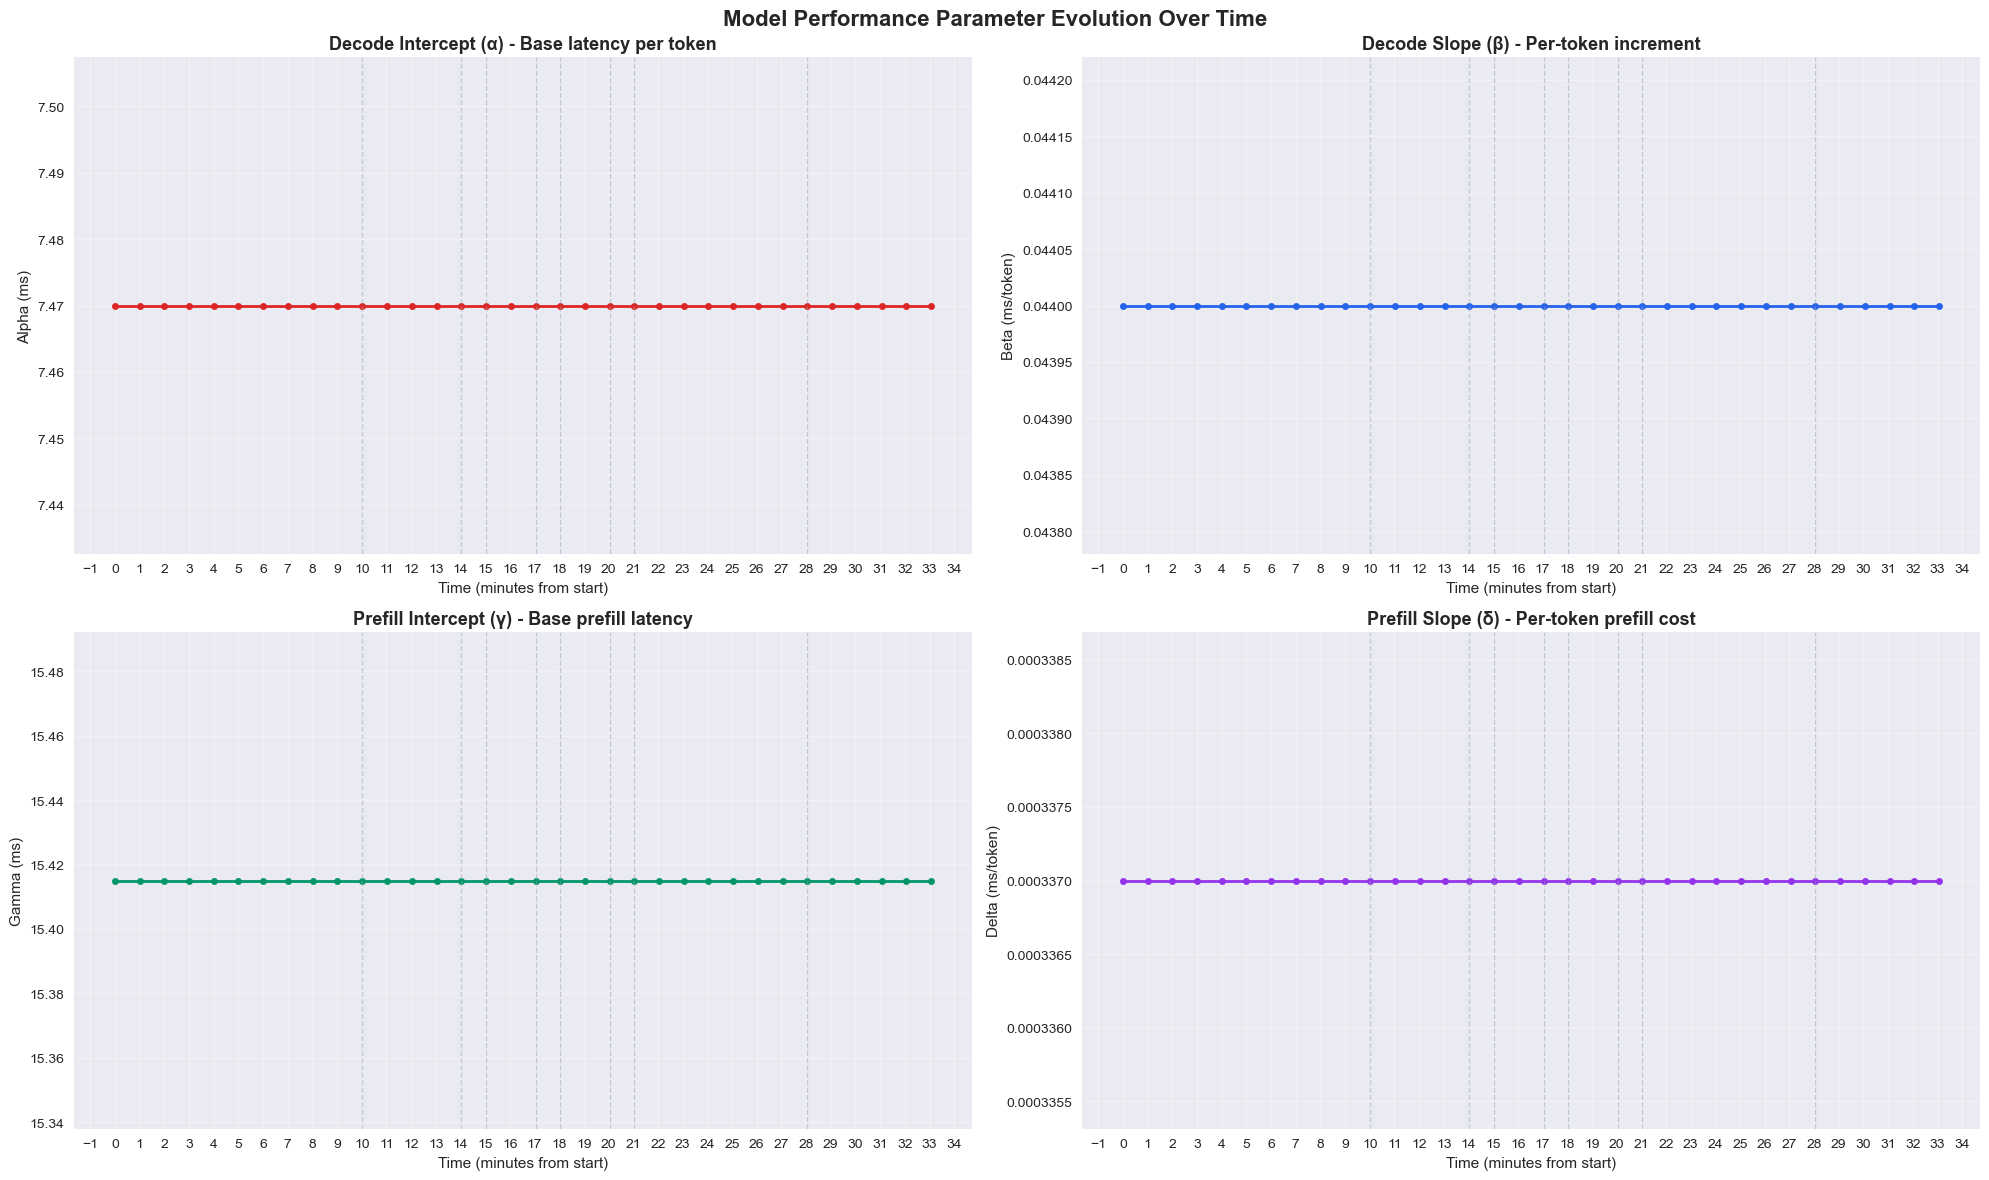

✅ Parameter evolution plot saved as 'experiments/20251209_141622_ttft_queuescorer_logs/plots/parameter_evolution.png'


In [152]:
if has_params:
    # Create parameter evolution visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Model Performance Parameter Evolution Over Time', fontweight='bold', fontsize=16)
    
    # Alpha (decode intercept)
    ax1.plot(df['time_minutes'], df['alpha'], 'o-', 
             linewidth=2, markersize=5, color='#dc2626', label='Alpha')
    ax1.set_xlabel('Time (minutes from start)', fontsize=11)
    ax1.set_ylabel('Alpha (ms)', fontsize=11)
    ax1.set_title('Decode Intercept (α) - Base latency per token', fontweight='bold', fontsize=13)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
    ax1.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
    # Better y-axis scaling with minimum padding
    alpha_min, alpha_max = df['alpha'].min(), df['alpha'].max()
    alpha_range = max(alpha_max - alpha_min, alpha_max * 0.05)  # At least 5% of max value
    ax1.set_ylim(alpha_min - alpha_range * 0.1, alpha_max + alpha_range * 0.1)
    
    # Mark scaling events
    for event in scaling_events:
        ax1.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.5, linewidth=1)
    
    # Beta (decode slope)
    ax2.plot(df['time_minutes'], df['beta'], 'o-', 
             linewidth=2, markersize=5, color='#2563eb', label='Beta')
    ax2.set_xlabel('Time (minutes from start)', fontsize=11)
    ax2.set_ylabel('Beta (ms/token)', fontsize=11)
    ax2.set_title('Decode Slope (β) - Per-token increment', fontweight='bold', fontsize=13)
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
    ax2.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
    # Better y-axis scaling with minimum padding
    beta_min, beta_max = df['beta'].min(), df['beta'].max()
    beta_range = max(beta_max - beta_min, beta_max * 0.05)  # At least 5% of max value
    ax2.set_ylim(beta_min - beta_range * 0.1, beta_max + beta_range * 0.1)
    
    # Mark scaling events
    for event in scaling_events:
        ax2.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.5, linewidth=1)
    
    # Gamma (prefill intercept)
    ax3.plot(df['time_minutes'], df['gamma'], 'o-', 
             linewidth=2, markersize=5, color='#059669', label='Gamma')
    ax3.set_xlabel('Time (minutes from start)', fontsize=11)
    ax3.set_ylabel('Gamma (ms)', fontsize=11)
    ax3.set_title('Prefill Intercept (γ) - Base prefill latency', fontweight='bold', fontsize=13)
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
    ax3.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
    # Better y-axis scaling with minimum padding
    gamma_min, gamma_max = df['gamma'].min(), df['gamma'].max()
    gamma_range = max(gamma_max - gamma_min, gamma_max * 0.05)  # At least 5% of max value
    ax3.set_ylim(gamma_min - gamma_range * 0.1, gamma_max + gamma_range * 0.1)
    
    # Mark scaling events
    for event in scaling_events:
        ax3.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.5, linewidth=1)
    
    # Delta (prefill slope)
    ax4.plot(df['time_minutes'], df['delta'], 'o-', 
             linewidth=2, markersize=5, color='#9333ea', label='Delta')
    ax4.set_xlabel('Time (minutes from start)', fontsize=11)
    ax4.set_ylabel('Delta (ms/token)', fontsize=11)
    ax4.set_title('Prefill Slope (δ) - Per-token prefill cost', fontweight='bold', fontsize=13)
    ax4.grid(True, alpha=0.3)
    ax4.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
    ax4.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
    # Better y-axis scaling with minimum padding
    delta_min, delta_max = df['delta'].min(), df['delta'].max()
    delta_range = max(delta_max - delta_min, delta_max * 0.05)  # At least 5% of max value
    ax4.set_ylim(delta_min - delta_range * 0.1, delta_max + delta_range * 0.1)
    
    # Mark scaling events
    for event in scaling_events:
        ax4.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.5, linewidth=1)
    
    plt.tight_layout()
    plot_path = f'{EXPERIMENT_DIR}/plots/parameter_evolution.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Parameter evolution plot saved as '{plot_path}'")

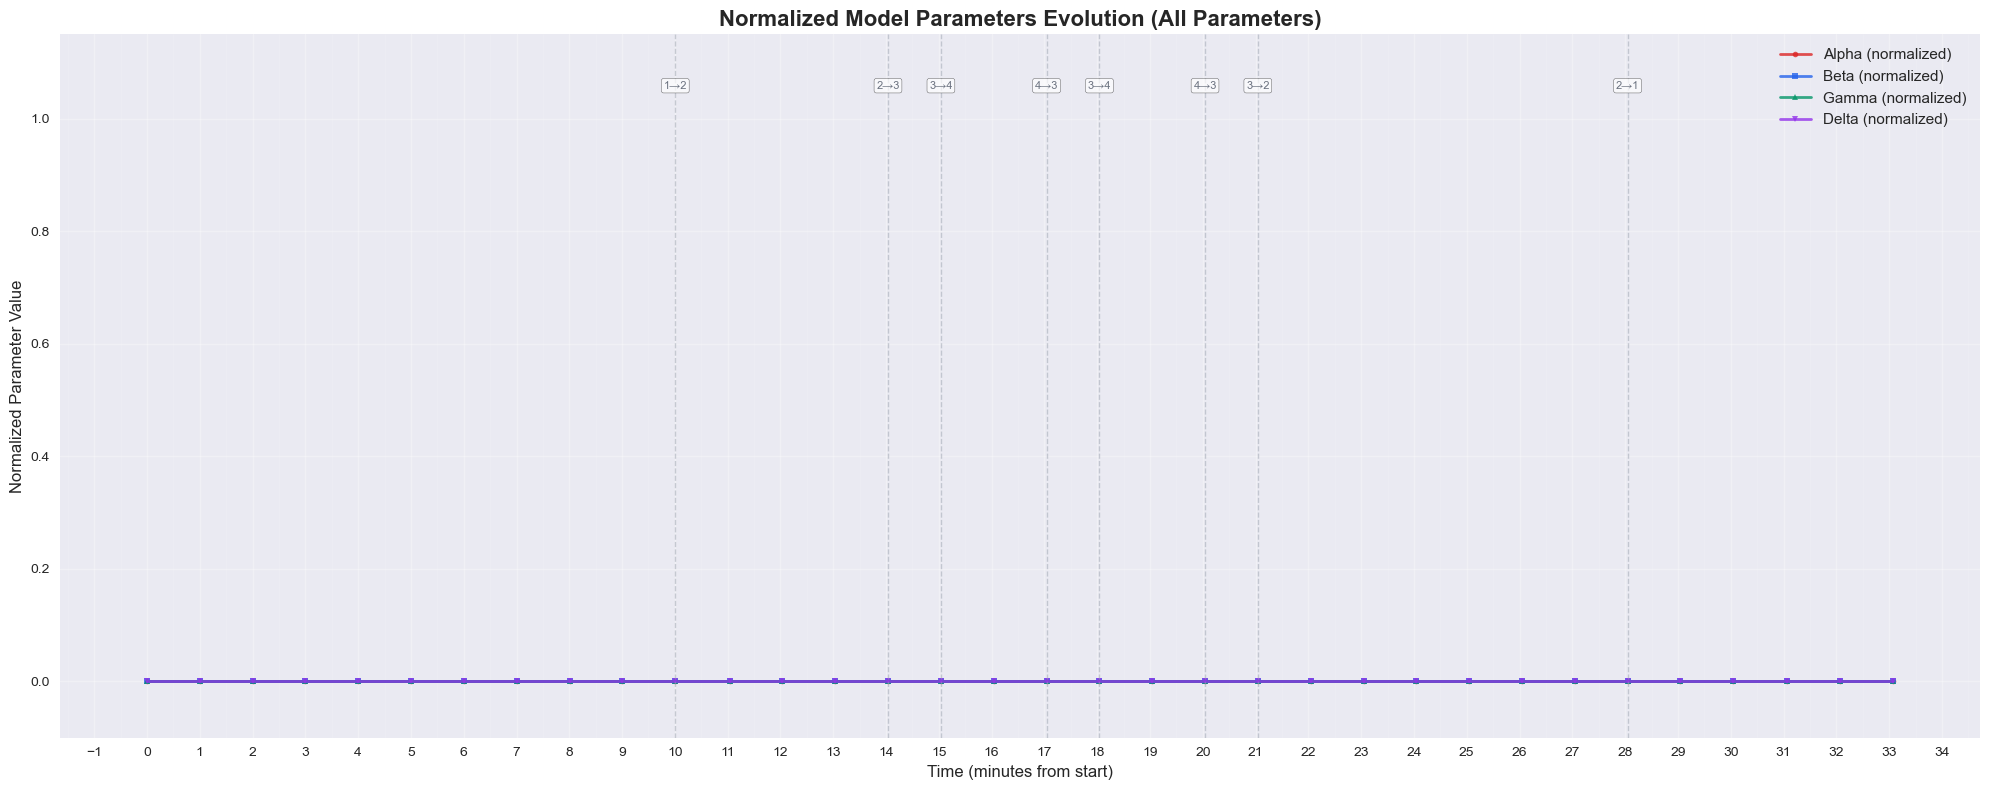

✅ Combined parameter evolution plot saved as 'experiments/20251209_141622_ttft_queuescorer_logs/plots/parameter_evolution_combined.png'


In [153]:
if has_params:
    # Combined view: All parameters on one plot
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # Normalize parameters to 0-1 range for comparison
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    params_normalized = pd.DataFrame({
        'alpha': scaler.fit_transform(df[['alpha']]).flatten(),
        'beta': scaler.fit_transform(df[['beta']]).flatten(),
        'gamma': scaler.fit_transform(df[['gamma']]).flatten(),
        'delta': scaler.fit_transform(df[['delta']]).flatten()
    }, index=df.index)
    
    ax.plot(df['time_minutes'], params_normalized['alpha'], 'o-', 
            linewidth=2, markersize=4, color='#dc2626', label='Alpha (normalized)', alpha=0.8)
    ax.plot(df['time_minutes'], params_normalized['beta'], 's-', 
            linewidth=2, markersize=4, color='#2563eb', label='Beta (normalized)', alpha=0.8)
    ax.plot(df['time_minutes'], params_normalized['gamma'], '^-', 
            linewidth=2, markersize=4, color='#059669', label='Gamma (normalized)', alpha=0.8)
    ax.plot(df['time_minutes'], params_normalized['delta'], 'v-', 
            linewidth=2, markersize=4, color='#9333ea', label='Delta (normalized)', alpha=0.8)
    
    # Mark scaling events
    for event in scaling_events:
        ax.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.5, linewidth=1)
        ax.text(event['time'], 1.05, f"{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
                ha='center', va='bottom', fontsize=8, color='#6b7280',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    ax.set_xlabel('Time (minutes from start)', fontsize=12)
    ax.set_ylabel('Normalized Parameter Value', fontsize=12)
    ax.set_title('Normalized Model Parameters Evolution (All Parameters)', 
                 fontweight='bold', fontsize=16)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.15)
    
    # Set x-axis granularity
    ax.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
    ax.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
    ax.grid(True, which='major', alpha=0.3, linewidth=1)
    ax.grid(True, which='minor', alpha=0.15, linewidth=0.5)
    
    plt.tight_layout()
    plot_path = f'{EXPERIMENT_DIR}/plots/parameter_evolution_combined.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Combined parameter evolution plot saved as '{plot_path}'")

In [154]:
if has_params:
    # Statistical summary of parameter evolution
    print("="*70)
    print("TUNER PARAMETER STATISTICS")
    print("="*70)
    
    for param in ['alpha', 'beta', 'gamma', 'delta']:
        print(f"\n{param.upper()}:")
        print(f"   Initial value: {df[param].iloc[0]:.6f}")
        print(f"   Final value: {df[param].iloc[-1]:.6f}")
        print(f"   Change: {df[param].iloc[-1] - df[param].iloc[0]:.6f}")
        print(f"   % Change: {((df[param].iloc[-1] - df[param].iloc[0]) / df[param].iloc[0] * 100):.2f}%")
        print(f"   Min: {df[param].min():.6f}")
        print(f"   Max: {df[param].max():.6f}")
        print(f"   Mean: {df[param].mean():.6f}")
        print(f"   Std Dev: {df[param].std():.6f}")
        print(f"   Coefficient of Variation: {(df[param].std() / df[param].mean() * 100):.2f}%")
    
    print("\n" + "="*70)
    print("TUNER CONVERGENCE ANALYSIS")
    print("="*70)
    
    # Calculate rate of change (first derivative approximation)
    window = 5  # Look at change over 5 minute windows
    for param in ['alpha', 'beta', 'gamma', 'delta']:
        if len(df) > window:
            df[f'{param}_rate_of_change'] = df[param].diff(window) / window
            recent_change = df[f'{param}_rate_of_change'].tail(10).abs().mean()
            early_change = df[f'{param}_rate_of_change'].head(10).abs().mean()
            
            print(f"\n{param.upper()} Rate of Change:")
            print(f"   Early phase (avg): {early_change:.6f} per minute")
            print(f"   Recent phase (avg): {recent_change:.6f} per minute")
            
            if recent_change < early_change * 0.5:
                print(f"   Status: ✓ Converging (rate reduced by {(1 - recent_change/early_change)*100:.1f}%)")
            elif recent_change > early_change * 1.5:
                print(f"   Status: ⚠️  Diverging (rate increased)")
            else:
                print(f"   Status: ~ Stable")
    
    print("\n" + "="*70)

TUNER PARAMETER STATISTICS

ALPHA:
   Initial value: 7.470000
   Final value: 7.470000
   Change: 0.000000
   % Change: 0.00%
   Min: 7.470000
   Max: 7.470000
   Mean: 7.470000
   Std Dev: 0.000000
   Coefficient of Variation: 0.00%

BETA:
   Initial value: 0.044000
   Final value: 0.044000
   Change: 0.000000
   % Change: 0.00%
   Min: 0.044000
   Max: 0.044000
   Mean: 0.044000
   Std Dev: 0.000000
   Coefficient of Variation: 0.00%

GAMMA:
   Initial value: 15.415000
   Final value: 15.415000
   Change: 0.000000
   % Change: 0.00%
   Min: 15.415000
   Max: 15.415000
   Mean: 15.415000
   Std Dev: 0.000000
   Coefficient of Variation: 0.00%

DELTA:
   Initial value: 0.000337
   Final value: 0.000337
   Change: 0.000000
   % Change: 0.00%
   Min: 0.000337
   Max: 0.000337
   Mean: 0.000337
   Std Dev: 0.000000
   Coefficient of Variation: 0.00%

TUNER CONVERGENCE ANALYSIS

ALPHA Rate of Change:
   Early phase (avg): 0.000000 per minute
   Recent phase (avg): 0.000000 per minute
   St

### Combined View: Decode Parameters (α, β) with ITL Performance

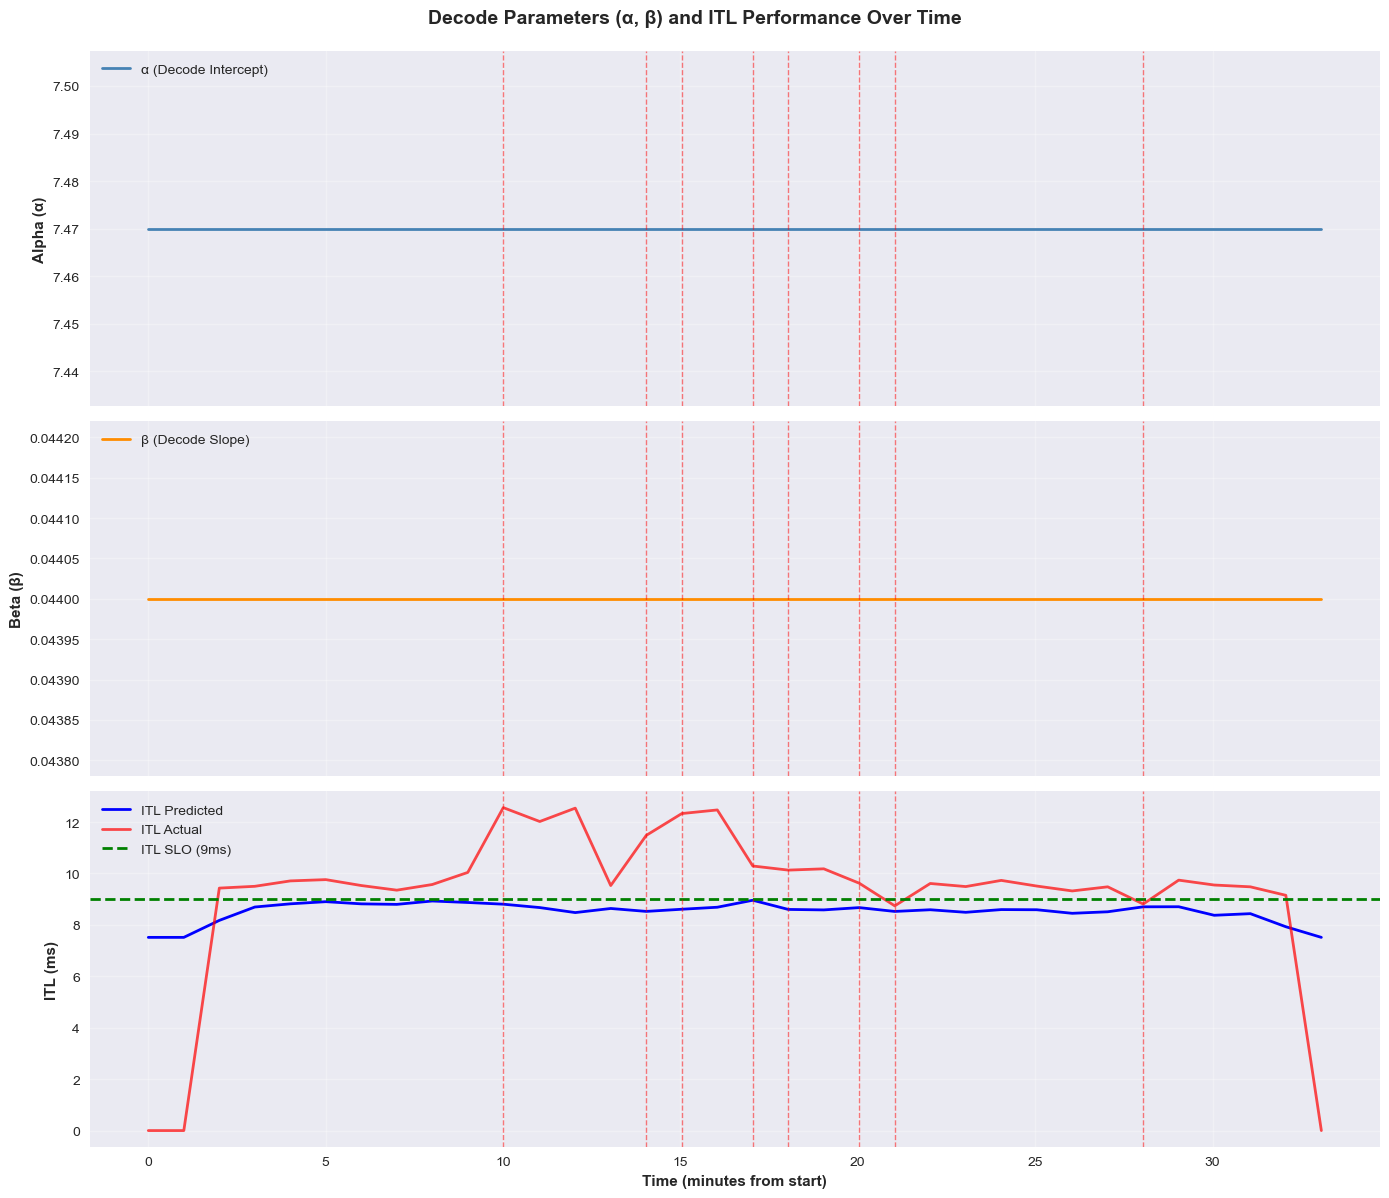

📊 This view shows how decode parameters (α, β) correlate with ITL performance
   - α (Alpha): Base decode latency per token
   - β (Beta): Incremental decode latency per token
   - ITL: Inter-Token Latency (affected by decode parameters)


In [155]:
if has_params:
    # Create figure with 3 subplots: Alpha, Beta, and ITL
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # Plot Alpha (Decode Intercept)
    ax1.plot(df['time_minutes'], df['alpha'], label='α (Decode Intercept)', color='steelblue', linewidth=2)
    alpha_min, alpha_max = df['alpha'].min(), df['alpha'].max()
    alpha_range = max(alpha_max - alpha_min, alpha_max * 0.05)
    ax1.set_ylim(alpha_min - alpha_range * 0.1, alpha_max + alpha_range * 0.1)
    ax1.set_ylabel('Alpha (α)', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # Add scaling events to Alpha
    for event in scaling_events:
        ax1.axvline(x=event['time'], color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    # Plot Beta (Decode Slope)
    ax2.plot(df['time_minutes'], df['beta'], label='β (Decode Slope)', color='darkorange', linewidth=2)
    beta_min, beta_max = df['beta'].min(), df['beta'].max()
    beta_range = max(beta_max - beta_min, beta_max * 0.05)
    ax2.set_ylim(beta_min - beta_range * 0.1, beta_max + beta_range * 0.1)
    ax2.set_ylabel('Beta (β)', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')
    
    # Add scaling events to Beta
    for event in scaling_events:
        ax2.axvline(x=event['time'], color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    # Plot ITL (Predicted vs Actual)
    ax3.plot(df['time_minutes'], df['itl'], label='ITL Predicted', color='blue', linewidth=2)
    ax3.plot(df['time_minutes'], df['itlAverage'], label='ITL Actual', color='red', linewidth=2, alpha=0.7)
    ax3.axhline(y=df['slo_itl'].iloc[0], color='green', linestyle='--', linewidth=2, label=f"ITL SLO ({df['slo_itl'].iloc[0]:.0f}ms)")
    ax3.set_ylabel('ITL (ms)', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Time (minutes from start)', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper left')
    
    # Add scaling events to ITL
    for event in scaling_events:
        ax3.axvline(x=event['time'], color='red', linestyle='--', alpha=0.5, linewidth=1, label='Scaling Event' if event == scaling_events[0] else '')
    
    plt.suptitle('Decode Parameters (α, β) and ITL Performance Over Time', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("📊 This view shows how decode parameters (α, β) correlate with ITL performance")
    print("   - α (Alpha): Base decode latency per token")
    print("   - β (Beta): Incremental decode latency per token")
    print("   - ITL: Inter-Token Latency (affected by decode parameters)")
else:
    print("⚠️ Parameter data not available. Please re-run extraction cells.")

### Combined View: Prefill Parameters (γ, δ) with TTFT Performance

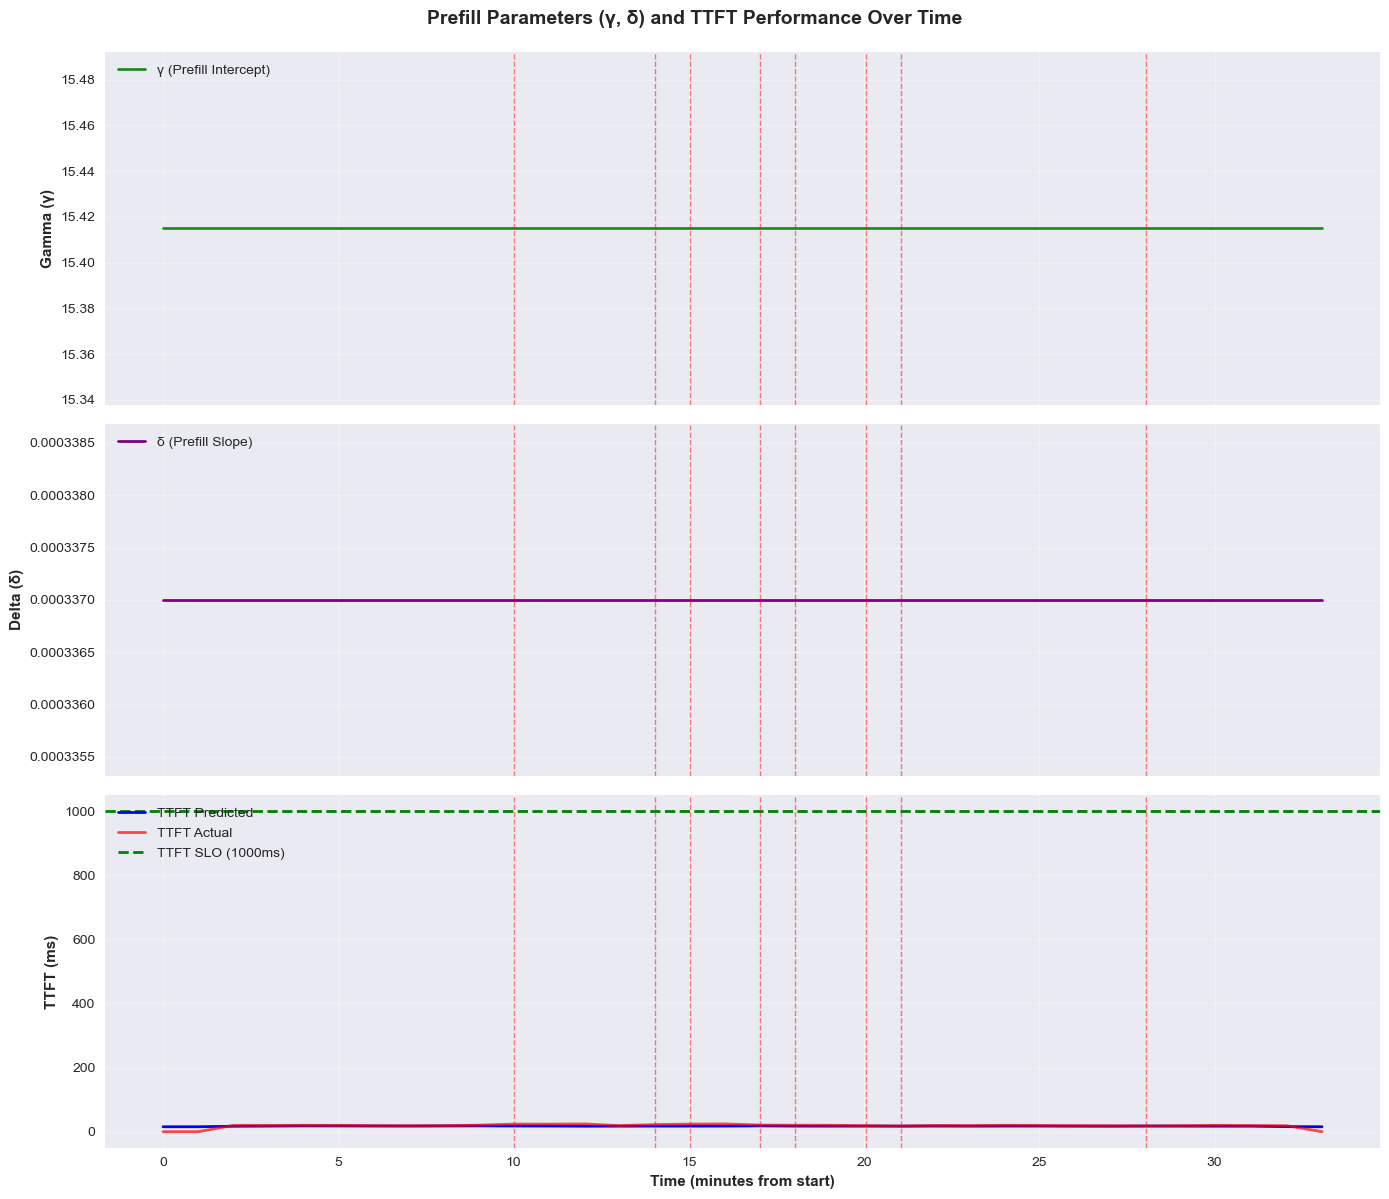

📊 This view shows how prefill parameters (γ, δ) correlate with TTFT performance
   - γ (Gamma): Base prefill latency
   - δ (Delta): Incremental prefill latency per token
   - TTFT: Time To First Token (affected by prefill parameters)


In [156]:
if has_params:
    # Create figure with 3 subplots: Gamma, Delta, and TTFT
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # Plot Gamma (Prefill Intercept)
    ax1.plot(df['time_minutes'], df['gamma'], label='γ (Prefill Intercept)', color='forestgreen', linewidth=2)
    gamma_min, gamma_max = df['gamma'].min(), df['gamma'].max()
    gamma_range = max(gamma_max - gamma_min, gamma_max * 0.05)
    ax1.set_ylim(gamma_min - gamma_range * 0.1, gamma_max + gamma_range * 0.1)
    ax1.set_ylabel('Gamma (γ)', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # Add scaling events to Gamma
    for event in scaling_events:
        ax1.axvline(x=event['time'], color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    # Plot Delta (Prefill Slope)
    ax2.plot(df['time_minutes'], df['delta'], label='δ (Prefill Slope)', color='purple', linewidth=2)
    delta_min, delta_max = df['delta'].min(), df['delta'].max()
    delta_range = max(delta_max - delta_min, delta_max * 0.05)
    ax2.set_ylim(delta_min - delta_range * 0.1, delta_max + delta_range * 0.1)
    ax2.set_ylabel('Delta (δ)', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')
    
    # Add scaling events to Delta
    for event in scaling_events:
        ax2.axvline(x=event['time'], color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    # Plot TTFT (Predicted vs Actual)
    ax3.plot(df['time_minutes'], df['ttft'], label='TTFT Predicted', color='blue', linewidth=2)
    ax3.plot(df['time_minutes'], df['ttftAverage'], label='TTFT Actual', color='red', linewidth=2, alpha=0.7)
    ax3.axhline(y=df['slo_ttft'].iloc[0], color='green', linestyle='--', linewidth=2, label=f"TTFT SLO ({df['slo_ttft'].iloc[0]:.0f}ms)")
    ax3.set_ylabel('TTFT (ms)', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Time (minutes from start)', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper left')
    
    # Add scaling events to TTFT
    for event in scaling_events:
        ax3.axvline(x=event['time'], color='red', linestyle='--', alpha=0.5, linewidth=1, label='Scaling Event' if event == scaling_events[0] else '')
    
    plt.suptitle('Prefill Parameters (γ, δ) and TTFT Performance Over Time', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("📊 This view shows how prefill parameters (γ, δ) correlate with TTFT performance")
    print("   - γ (Gamma): Base prefill latency")
    print("   - δ (Delta): Incremental prefill latency per token")
    print("   - TTFT: Time To First Token (affected by prefill parameters)")
else:
    print("⚠️ Parameter data not available. Please re-run extraction cells.")